Imports

In [27]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import os
import pickle
import warnings
import math
from tqdm import tqdm
import scipy.optimize as sco

# Ignorer les avertissements
warnings.filterwarnings('ignore')
print("Bibliothèques importées.")

Bibliothèques importées.


Définitions des Fonctions

In [29]:
# Fonctions utilitaires (Pickle)

def sauvegarder_donnees_pickle(obj, path):
    """Sauvegarde un objet dans un fichier pickle."""
    with open(path, "wb") as f:
        pickle.dump(obj, f)
    print(f"Données sauvegardées dans : {path}")

def charger_donnees_pickle(path):
    """Charge un objet depuis un fichier pickle."""
    if os.path.exists(path):
        with open(path, "rb") as f:
            return pickle.load(f)
    print(f"Fichier pickle introuvable : {path}")
    return {}

# Fonctions de Collecte et Traitement des Données

def telecharger_donnees_yahoo(tickers, start, end, output_dir):
    """Télécharge les données Yahoo Finance pour les tickers manquants."""
    os.makedirs(output_dir, exist_ok=True)
    for ticker in tickers:
        filepath = os.path.join(output_dir, f"data_{ticker}.csv")
        if not os.path.exists(filepath):
            print(f"Téléchargement de {ticker}...")
            df = yf.download(ticker, start=start, end=end)
            if not df.empty:
                df.to_csv(filepath)
            else:
                print(f"Aucune donnée trouvée pour {ticker}")
    return

def compute_rsi(series, period=14):
    """Calcule le Relative Strength Index (RSI)."""
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def compute_indicators(df):
    """Calcule les indicateurs techniques sur les données mensuelles."""
    df_copy = df.copy()
    df_copy['Return'] = df_copy['Close'].pct_change()
    df_copy['Rendement Cumulatif'] = (1 + df_copy['Return']).cumprod()
    df_copy['SMA20'] = df_copy['Close'].rolling(window=20).mean()
    df_copy['SMA50'] = df_copy['Close'].rolling(window=50).mean()
    df_copy['RSI'] = compute_rsi(df_copy['Close'], period=14)
    df_copy['EMA12'] = df_copy['Close'].ewm(span=12, adjust=False).mean()
    df_copy['EMA26'] = df_copy['Close'].ewm(span=26, adjust=False).mean()
    df_copy['MACD'] = df_copy['EMA12'] - df_copy['EMA26']
    df_copy['TR'] = np.maximum.reduce([df_copy['High'] - df_copy['Low'], np.abs(df_copy['High'] - df_copy['Close'].shift()), np.abs(df_copy['Low'] - df_copy['Close'].shift())])
    df_copy['ATR'] = df_copy['TR'].rolling(window=14).mean()
    df_copy['Volatilite_12m'] = df_copy['Return'].rolling(window=12).std() * np.sqrt(12)
    df_copy['Cumulative Max'] = df_copy['Rendement Cumulatif'].cummax()
    df_copy['Drawdown'] = df_copy['Rendement Cumulatif'] / df_copy['Cumulative Max'] - 1
    df_copy = df_copy.replace([np.inf, -np.inf], np.nan)
    return df_copy.dropna(subset=['Close'])

def load_and_process_data(tickers, output_dir, pickle_path, analysis_start, analysis_end, buffer_period, cols_to_convert):
    """Charge les données (Pickle ou CSV/Téléchargement) et les traite."""
    data_dict = charger_donnees_pickle(pickle_path)
    is_processed = True
    if not data_dict:
        is_processed = False
    else:
        for ticker in tickers:
            if ticker not in data_dict or data_dict[ticker].index.min() > analysis_start or data_dict[ticker].index.max() < (analysis_end - pd.DateOffset(days=3)):
                is_processed = False
                break
                        
    if is_processed:
        print(f"Données mensuelles traitées chargées depuis {pickle_path}.")
        return data_dict

    print("Données non trouvées ou obsolètes. Téléchargement et traitement...")
    download_start = analysis_start - buffer_period
    download_end = analysis_end
    
    telecharger_donnees_yahoo(tickers, start=download_start.strftime('%Y-%m-%d'), end=download_end.strftime('%Y-%m-%d'), output_dir=output_dir)

    data_dict = {}
    for ticker in tickers:
        filename = os.path.join(output_dir, f"data_{ticker}.csv")
        if os.path.exists(filename):
            df = pd.read_csv(filename, index_col=0, parse_dates=True)
            df.index = pd.to_datetime(df.index, errors='coerce')
            df = df[df.index.notna()]
            for col in cols_to_convert:
                if col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
            df_monthly = df.resample('M').last()
            df_computed = compute_indicators(df_monthly)
            df_analysis = df_computed.loc[analysis_start:analysis_end].copy()
            data_dict[ticker] = df_analysis
        else:
            print(f"Aucune donnée CSV trouvée pour {ticker}.")
    
    sauvegarder_donnees_pickle(data_dict, pickle_path)
    return data_dict

# Fonctions de Stratégie (Signaux)

def get_scalar(value):
    """Extrait une valeur scalaire d'une Série ou retourne la valeur."""
    if isinstance(value, pd.Series):
        return value.iloc[0]
    return value

def buy_signal_threshold(prev, curr, median_atr, median_vol, threshold):
    """Définit les conditions d'achat."""
    conditions = {
        'SMA': get_scalar(curr['SMA20']) > get_scalar(curr['SMA50']),
        'RSI': get_scalar(curr['RSI']) < 30,
        'MACD': get_scalar(curr['MACD']) > 0,
        'Cumulative': get_scalar(curr['Rendement Cumulatif']) > get_scalar(prev['Rendement Cumulatif']),
        'ATR': get_scalar(curr['ATR']) < median_atr,
        'Volatility': get_scalar(curr['Volatilite_12m']) < median_vol
    }
    return sum(conditions.values()) >= threshold

def sell_signal_threshold(prev, curr, median_atr, median_vol, threshold):
    """Définit les conditions de vente."""
    conditions = {
        'SMA': get_scalar(curr['SMA20']) < get_scalar(curr['SMA50']),
        'RSI': get_scalar(curr['RSI']) > 70,
        'MACD': get_scalar(curr['MACD']) < 0,
        'Cumulative': get_scalar(curr['Rendement Cumulatif']) < get_scalar(prev['Rendement Cumulatif']),
        'ATR': get_scalar(curr['ATR']) > median_atr,
        'Volatility': get_scalar(curr['Volatilite_12m']) > median_vol
    }
    return sum(conditions.values()) >= threshold

# Fonction de Backtest Visuel (P&L et Drawdown)

def run_visual_backtest(df, thr, initial_capital):
    """
    Exécute le backtest et génère la courbe d'équité, les signaux
    et les statistiques de performance (P&L, Max Drawdown).
    """
    if df is None or df.empty or len(df) < 2:
        return None
    
    df_equity = df[['Close']].copy()
    df_equity['Cash'] = 0.0
    df_equity['Positions'] = 0.0
    df_equity['Equity'] = initial_capital
    df_equity['Buy_Signal'] = np.nan
    df_equity['Sell_Signal'] = np.nan
    
    cash = initial_capital
    positions = 0.0
    in_position = False
    
    median_atr = df['ATR'].median()
    median_vol = df['Volatilite_12m'].median()
    
    if pd.isna(median_atr) or pd.isna(median_vol):
        print(f"Données insuffisantes pour les médianes ATR/Vol.")
        return None
        
    for i in range(1, len(df_equity)):
        prev = df.iloc[i-1]
        curr = df.iloc[i]
        
        df_equity.at[df_equity.index[i], 'Cash'] = cash
        df_equity.at[df_equity.index[i], 'Positions'] = positions
        
        current_equity = cash + (positions * curr['Close'])
        df_equity.at[df_equity.index[i], 'Equity'] = current_equity
        
        if pd.isna(curr['SMA20']) or pd.isna(curr['SMA50']) or pd.isna(curr['RSI']) or \
           pd.isna(curr['MACD']) or pd.isna(curr['ATR']) or pd.isna(curr['Volatilite_12m']):
            continue
        
        if not in_position and buy_signal_threshold(prev, curr, median_atr, median_vol, thr):
            positions = cash / curr['Close']
            cash = 0.0
            in_position = True
            df_equity.at[df_equity.index[i], 'Buy_Signal'] = curr['Close']
        
        elif in_position and sell_signal_threshold(prev, curr, median_atr, median_vol, thr):
            cash = positions * curr['Close']
            positions = 0.0
            in_position = False
            df_equity.at[df_equity.index[i], 'Sell_Signal'] = curr['Close']
    
    # Calcul des Statistiques Finales
    final_equity = df_equity['Equity'].iloc[-1]
    total_return_pct = (final_equity / initial_capital) - 1
    pnl_euros = final_equity - initial_capital
    
    df_equity['Cumulative_Max_Equity'] = df_equity['Equity'].cummax()
    df_equity['Drawdown'] = (df_equity['Equity'] / df_equity['Cumulative_Max_Equity']) - 1
    max_drawdown = df_equity['Drawdown'].min()
    
    stats = {
        'Final_Equity': final_equity,
        'Total_Return_Pct': total_return_pct,
        'PNL_Euros': pnl_euros,
        'Max_Drawdown': max_drawdown,
        'Start_Capital': initial_capital
    }
    
    return {'equity_df': df_equity, 'stats': stats}

# Fonction Graphique de Backtest Détaillé

def plot_backtest_results(df_asset, backtest_results, ticker_label, thr):
    """
    Affiche un graphique en 3 parties:
    1. Prix + Signaux Achat/Vente
    2. Courbe d'Équité (P&L en €/$)
    3. Courbe de Drawdown de la stratégie
    """
    if backtest_results is None:
        print(f"Pas de résultats à afficher pour {ticker_label} (Seuil {thr}/6)")
        return
        
    equity_df = backtest_results['equity_df']
    stats = backtest_results['stats']
    
    fig = plt.figure(figsize=(14, 10))
    gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1], hspace=0.1)
    
    # Graphique 1: Prix et Signaux
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(df_asset.index, df_asset['Close'], label='Prix Clôture', color='black', alpha=0.8)
    ax1.plot(df_asset.index, df_asset['SMA20'], label='SMA20', color='blue', alpha=0.3, linestyle='--')
    ax1.plot(df_asset.index, df_asset['SMA50'], label='SMA50', color='orange', alpha=0.3, linestyle='--')
    
    ax1.scatter(equity_df.index, equity_df['Buy_Signal'], label='Achat', marker='^', color='green', s=100, alpha=1, zorder=5)
    ax1.scatter(equity_df.index, equity_df['Sell_Signal'], label='Vente', marker='v', color='red', s=100, alpha=1, zorder=5)
    
    ax1.set_title(f"Stratégie (Seuil {thr}/6) - {ticker_label}", fontsize=14, fontweight='bold')
    ax1.set_ylabel("Prix")
    ax1.legend(loc='upper left')
    ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    
    # Graphique 2: Performance (P&L)
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax2.plot(equity_df.index, equity_df['Equity'], label='Valeur Portefeuille', color='purple')
    ax2.axhline(y=stats['Start_Capital'], color='grey', linestyle='--', label=f'Capital Initial ({stats["Start_Capital"]})')
    ax2.set_ylabel("Valeur Portefeuille (€/$)")
    ax2.set_title(f"Performance: {stats['PNL_Euros']:,.2f} €/$ (Rend: {stats['Total_Return_Pct']:.2%})", loc='left', fontsize=10)
    ax2.legend(loc='upper left')
    ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    # Graphique 3: Drawdown
    ax3 = fig.add_subplot(gs[2], sharex=ax1)
    ax3.fill_between(equity_df.index, equity_df['Drawdown'], 0, color='red', alpha=0.5, label='Drawdown')
    ax3.set_ylabel("Drawdown Stratégie")
    ax3.set_xlabel("Date")
    ax3.set_title(f"Max Drawdown de la Stratégie: {stats['Max_Drawdown']:.2%}", loc='left', fontsize=10)
    ax3.yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
    ax3.legend(loc='lower left')
    
    plt.tight_layout(h_pad=0)
    plt.show()

# Fonction Heatmap de Corrélation

def plot_correlation_heatmap(data_dict, tickers, labels_dict, title="Matrice de Corrélation des Rendements"):
    """Calcule et affiche une heatmap de corrélation des rendements mensuels."""
    returns_list = []
    for ticker in tickers:
        if ticker in data_dict and 'Return' in data_dict[ticker].columns:
            label = labels_dict.get(ticker, ticker)
            returns_list.append(data_dict[ticker]['Return'].rename(label))
    
    returns_df = pd.concat(returns_list, axis=1).dropna()
            
    if returns_df.empty:
        print("Pas de données de rendement pour la corrélation.")
        return
        
    corr_matrix = returns_df.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={"size": 8})
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Fonction d'Analyse des Seuils (Stats) 

def run_backtest_for_stats(df, thr):
    """Version légère du backtest, ne retournant que les trades pour les stats."""
    if df is None or df.empty or len(df) < 2: return []
    median_atr = df['ATR'].median()
    median_vol = df['Volatilite_12m'].median()
    if pd.isna(median_atr) or pd.isna(median_vol): return []

    trades = []
    in_position = False
    entry_price = None
    for i in range(1, len(df)):
        prev = df.iloc[i-1]
        curr = df.iloc[i]
        if pd.isna(curr['SMA20']) or pd.isna(curr['SMA50']): continue
        if not in_position and buy_signal_threshold(prev, curr, median_atr, median_vol, thr):
            in_position = True
            entry_price = curr['Close']
        elif in_position and sell_signal_threshold(prev, curr, median_atr, median_vol, thr):
            in_position = False
            trade_return = (curr['Close'] / entry_price) - 1
            trades.append({'ret': trade_return})
    return trades

def analyze_thresholds(data_dict, tickers_to_analyze, group_label):
    """Analyse la performance (Win Rate, Rend. Moyen) pour les seuils 1/6 à 6/6."""
    print(f"\n--- Analyse des Seuils de Stratégie pour: {group_label} ---")
    all_metrics = []
    for thr in range(1, 7):
        all_trades_for_thr = []
        for ticker in tqdm(tickers_to_analyze, desc=f"Test Seuil {thr}/6", leave=False):
            if ticker in data_dict:
                trades = run_backtest_for_stats(data_dict[ticker], thr)
                all_trades_for_thr.extend(trades)
        
        if not all_trades_for_thr:
            metrics = {'Seuil': f"{thr}/6", 'Total Trades': 0, 'Win Rate': np.nan, 'Rendement Moyen': np.nan}
        else:
            df_trades = pd.DataFrame(all_trades_for_thr)
            metrics = {
                'Seuil': f"{thr}/6",
                'Total Trades': len(df_trades),
                'Win Rate': (df_trades['ret'] > 0).mean(),
                'Rendement Moyen': df_trades['ret'].mean()
            }
        all_metrics.append(metrics)
    
    df_results = pd.DataFrame(all_metrics).set_index('Seuil')
    df_display = df_results.copy()
    df_display['Win Rate'] = df_display['Win Rate'].map(lambda x: f"{x:.2%}" if pd.notna(x) else "N/A")
    df_display['Rendement Moyen'] = df_display['Rendement Moyen'].map(lambda x: f"{x:.2%}" if pd.notna(x) else "N/A")
    
    print("\nTableau de performance (Agrégé sur tous les actifs):")
    print(df_display)
    
    best_thr_idx = df_results['Rendement Moyen'].idxmax()
    best_perf = df_results.loc[best_thr_idx, 'Rendement Moyen']
    print(f"\nMeilleur seuil (basé sur Rendement Moyen) pour '{group_label}': {best_thr_idx} (Rend. Moyen: {best_perf:.2%})")
    
    return df_results, best_thr_idx, int(best_thr_idx[0])

# Fonctions d'Optimisation de Portefeuille

def calculer_rendements_mensuels(df_dict, tickers):
    """Prépare les rendements mensuels pour l'optimisation."""
    returns_list = []
    for ticker in tickers:
        if ticker in df_dict and 'Return' in df_dict[ticker].columns:
            returns_list.append(df_dict[ticker]['Return'].rename(ticker))
    return pd.concat(returns_list, axis=1).dropna()

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    """Ratio de Sharpe négatif (pour minimisation)."""
    p_ret = np.sum(mean_returns * weights)
    p_var = np.dot(weights.T, np.dot(cov_matrix, weights))
    p_std = np.sqrt(p_var)
    if p_std == 0:
        return 0
    return -(p_ret - risk_free_rate) / p_std

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    """Optimisation pour Max Sharpe Ratio."""
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    return sco.minimize(neg_sharpe_ratio, num_assets * [1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

def portfolio_variance(weights, mean_returns, cov_matrix):
    """Variance du portefeuille."""
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def min_variance(mean_returns, cov_matrix):
    """Optimisation pour Min Variance."""
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    return sco.minimize(portfolio_variance, num_assets * [1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

def calculate_portfolio_performance(weights, mean_returns, cov_matrix):
    """Calcule le rendement et la volatilité annualisés."""
    ret = np.sum(mean_returns * weights) * 12
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(12)
    return std, ret

def display_simulated_portfolios(mean_returns, cov_matrix, risk_free_rate, results_sharpe, results_min_var):
    """Affiche la Frontière Efficiente (Simulation Monte Carlo)."""
    print("\n--- Graphique d'Optimisation (Frontière Efficiente) ---")
    num_portfolios = 10000
    all_weights = np.zeros((num_portfolios, len(mean_returns)))
    ret_arr = np.zeros(num_portfolios)
    vol_arr = np.zeros(num_portfolios)
    sharpe_arr = np.zeros(num_portfolios)

    for i in range(num_portfolios):
        w = np.array(np.random.random(len(mean_returns)))
        w = w / np.sum(w)
        all_weights[i,:] = w
        vol_arr[i], ret_arr[i] = calculate_portfolio_performance(w, mean_returns, cov_matrix)
        sharpe_arr[i] = (ret_arr[i] - risk_free_rate) / vol_arr[i]

    plt.figure(figsize=(10, 6))
    plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis', marker='o', s=10, alpha=0.3)
    plt.colorbar(label='Ratio de Sharpe')
    
    std_opt, ret_opt = calculate_portfolio_performance(results_sharpe['x'], mean_returns, cov_matrix)
    plt.scatter(std_opt, ret_opt, marker='*', color='g', s=200, label=f'Max Sharpe (Opt: {results_sharpe.fun * -1:.2f})')
    
    std_min_opt, ret_min_opt = calculate_portfolio_performance(results_min_var['x'], mean_returns, cov_matrix)
    plt.scatter(std_min_opt, ret_min_opt, marker='*', color='orange', s=200, label=f'Min Volatilité (Opt: {np.sqrt(results_min_var.fun) * np.sqrt(12):.2%})')
    
    plt.title('Simulation de Monte Carlo (Frontière Efficiente)')
    plt.xlabel('Volatilité (Annualisée)')
    plt.ylabel('Rendement (Annualisé)')
    plt.legend()
    plt.show()

def optimize_portfolio(df_dict, tickers, risk_free_rate=0.01):
    """Fonction principale d'optimisation."""
    returns_df = calculer_rendements_mensuels(df_dict, tickers)
    tickers_communs = list(set(returns_df.columns))
    returns_filtered = returns_df[tickers_communs]
    
    if returns_filtered.empty or len(tickers_communs) < 2:
        print("Pas assez de données de rendement pour l'optimisation.")
        return

    mean_returns = returns_filtered.mean()
    cov_matrix = returns_filtered.cov()
    
    results_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    results_min_var = min_variance(mean_returns, cov_matrix)
    
    display_simulated_portfolios(mean_returns, cov_matrix, risk_free_rate, results_sharpe, results_min_var)


Paramètres Globaux

In [30]:
# Modifier ce chemin pour correspondre à votre configuration
OUTPUT_DIR = "C:/Users/Karine/Desktop/Projet_gestion_portefeuille/"

COLS_TO_CONVERT = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
ANALYSIS_START = pd.to_datetime("2015-01-01")
ANALYSIS_END = pd.to_datetime("2025-12-31")
BUFFER_PERIOD = pd.DateOffset(months=24)
RISK_FREE_RATE = 0.01

# Labels pour les graphiques
TICKERS_LABEL_EU = {
    "ASML.AS": "ASML", "SAP.DE": "SAP", "IFX.DE": "Infineon", "STMPA.PA": "STMicro", "ERIC-B.ST": "Ericsson",
    "SAN.PA": "Sanofi", "NOVO-B.CO": "Novo Nordisk", "BAYN.DE": "Bayer", "ROG.SW": "Roche", "AZN.L": "AstraZeneca",
    "NESN.SW": "Nestlé", "ULVR.L": "Unilever", "BN.PA": "Danone", "CA.PA": "Carrefour", "MC.PA": "LVMH", "KER.PA": "Kering"
}

TICKERS_LABEL_US = {
    'MSFT': 'Microsoft', 'AAPL': 'Apple', 'GOOGL': 'Google', 'AMZN': 'Amazon', 'TSLA': 'Tesla', 'NVDA': 'Nvidia'
}

print("Paramètres globaux définis.")
print(f"Dossier de travail : {OUTPUT_DIR}")

Paramètres globaux définis.
Dossier de travail : C:/Users/Karine/Desktop/Projet_gestion_portefeuille/


PARTIE 1 - Analyse Portefeuille Principal (EU)

In [31]:
TICKERS_EU = list(TICKERS_LABEL_EU.keys())
PICKLE_PATH_EU = os.path.join(OUTPUT_DIR, "df_dict_processed_monthly_EU.pkl")
CAPITAL_INITIAL_EU = 100000

# Chargement des données
data_dict_eu = load_and_process_data(
    tickers=TICKERS_EU,
    output_dir=OUTPUT_DIR,
    pickle_path=PICKLE_PATH_EU,
    analysis_start=ANALYSIS_START,
    analysis_end=ANALYSIS_END,
    buffer_period=BUFFER_PERIOD,
    cols_to_convert=COLS_TO_CONVERT
)

print(f"\nDonnées chargées pour {len(data_dict_eu)} tickers EU")

Données non trouvées ou obsolètes. Téléchargement et traitement...
Données sauvegardées dans : C:/Users/Karine/Desktop/Projet_gestion_portefeuille/df_dict_processed_monthly_EU.pkl

Données chargées pour 16 tickers EU


PARTIE 1 - Analyse de Corrélation (EU)

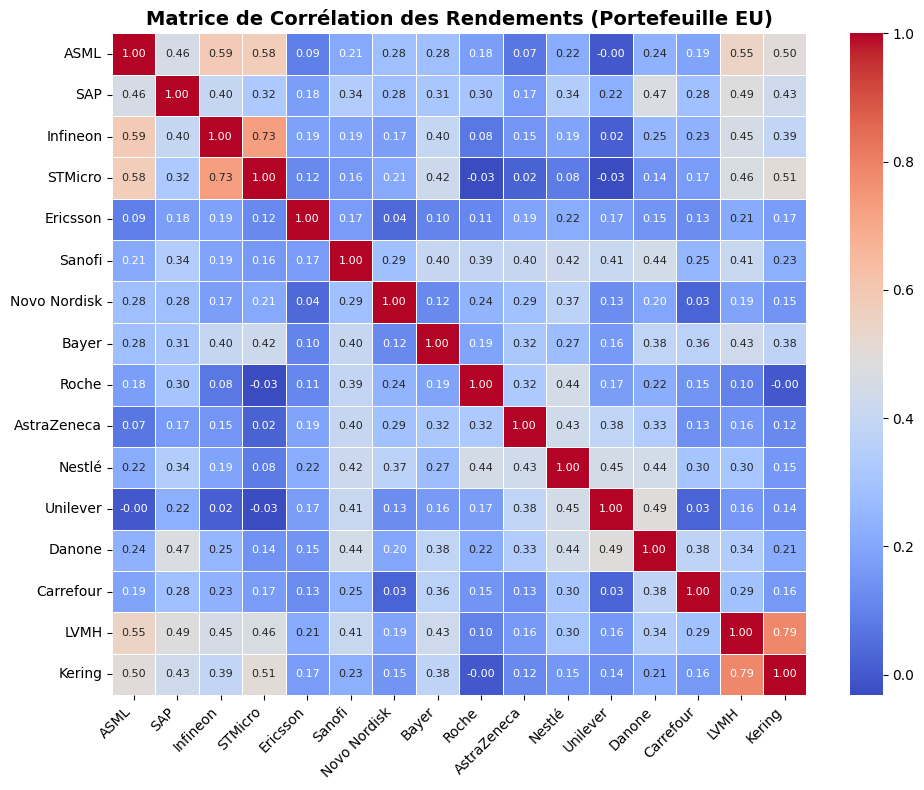

In [32]:
if 'data_dict_eu' in locals() and data_dict_eu:
    plot_correlation_heatmap(data_dict_eu, TICKERS_EU, TICKERS_LABEL_EU, 
                             title="Matrice de Corrélation des Rendements (Portefeuille EU)")
else:
    print("'data_dict_eu' non chargé. Exécutez la cellule précédente.")

PARTIE 1 - Analyse des Seuils (Tableau Récap)

In [33]:
if 'data_dict_eu' in locals() and data_dict_eu:
    results_eu, best_thr_label_eu, best_thr_num_eu = analyze_thresholds(
        data_dict=data_dict_eu,
        tickers_to_analyze=TICKERS_EU,
        group_label="Portefeuille Principal (EU)"
    )
else:
    print("'data_dict_eu' non chargé. Exécutez la cellule 4.")
    best_thr_num_eu = 4 # Valeur par défaut si l'analyse échoue


--- Analyse des Seuils de Stratégie pour: Portefeuille Principal (EU) ---



Tableau de performance (Agrégé sur tous les actifs):
       Total Trades Win Rate Rendement Moyen
Seuil                                       
1/6             968   52.58%           1.01%
2/6             701   47.79%           1.14%
3/6             266   43.61%           5.14%
4/6              37   51.35%          39.35%
5/6              10   70.00%          81.12%
6/6               0      N/A             N/A

Meilleur seuil (basé sur Rendement Moyen) pour 'Portefeuille Principal (EU)': 5/6 (Rend. Moyen: 81.12%)


PARTIE 1 - Backtest Visuel Détaillé (EU)

Utilisation du meilleur seuil identifié: 5/6


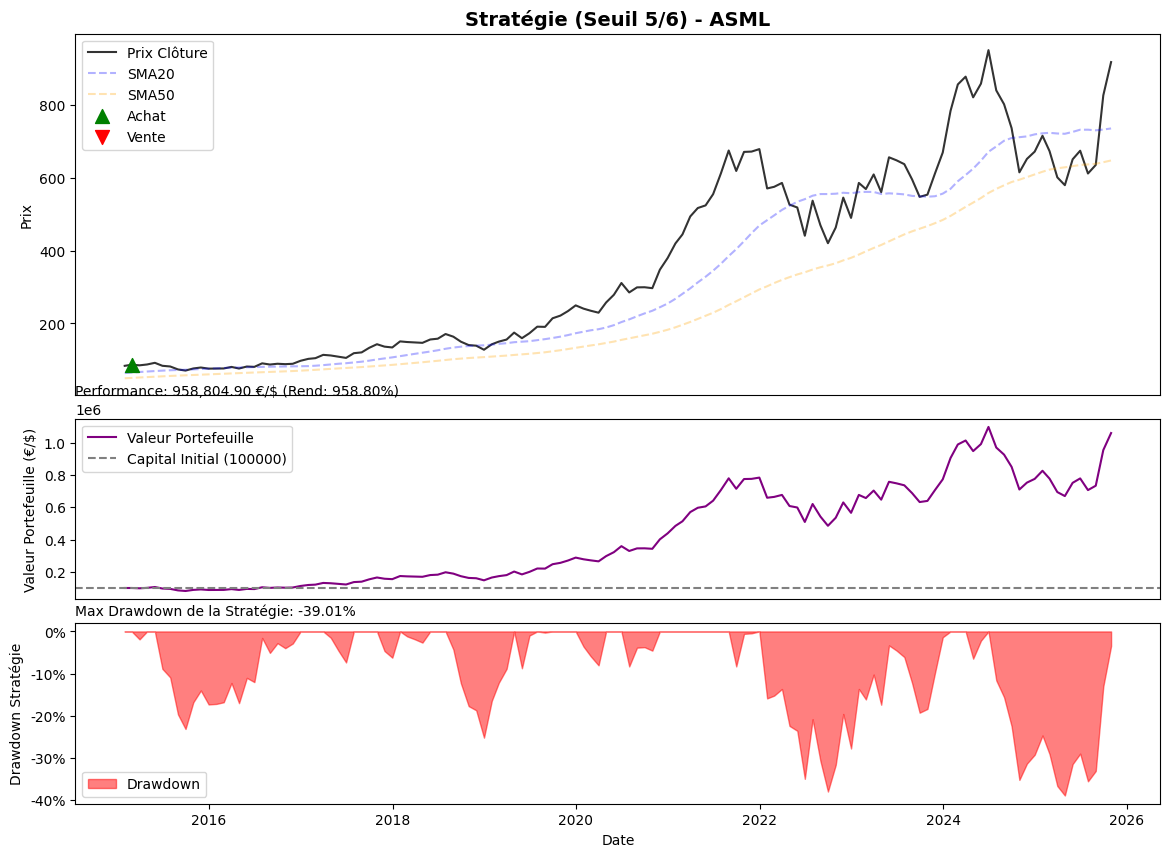

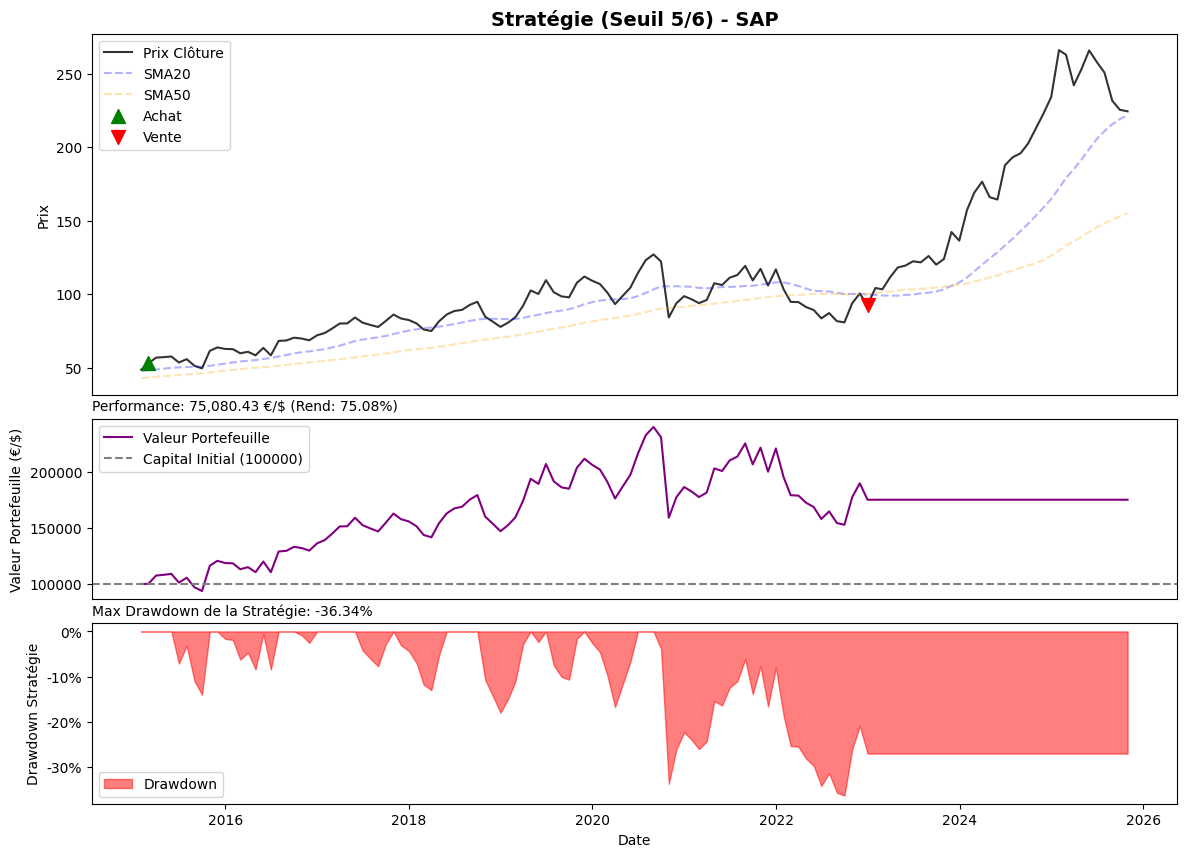

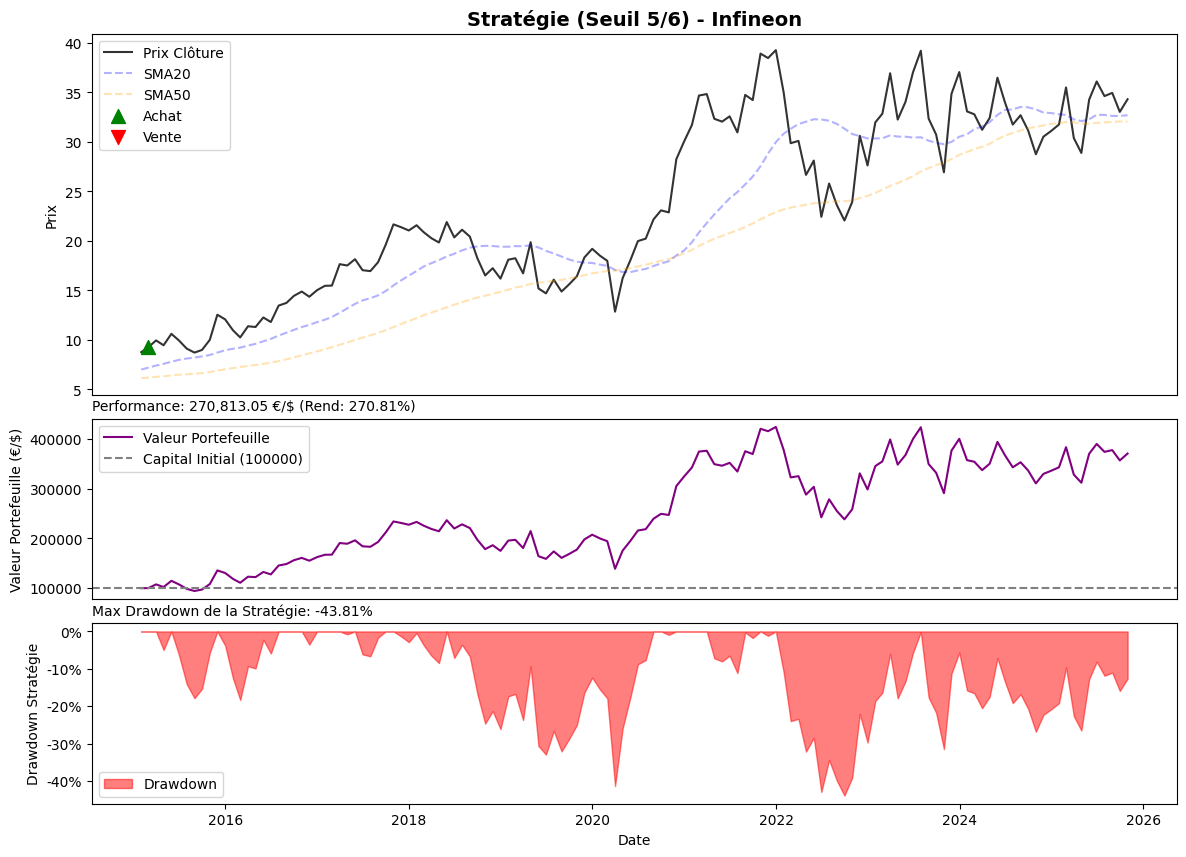

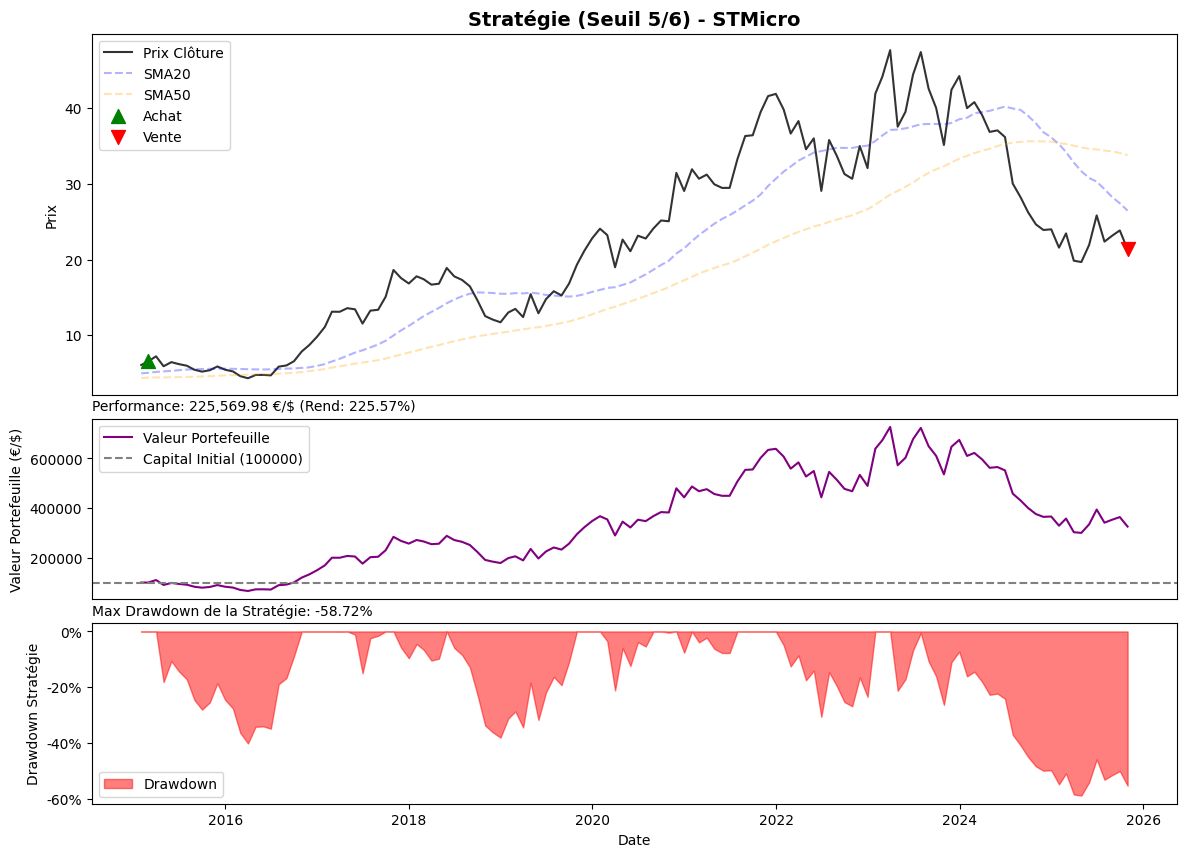

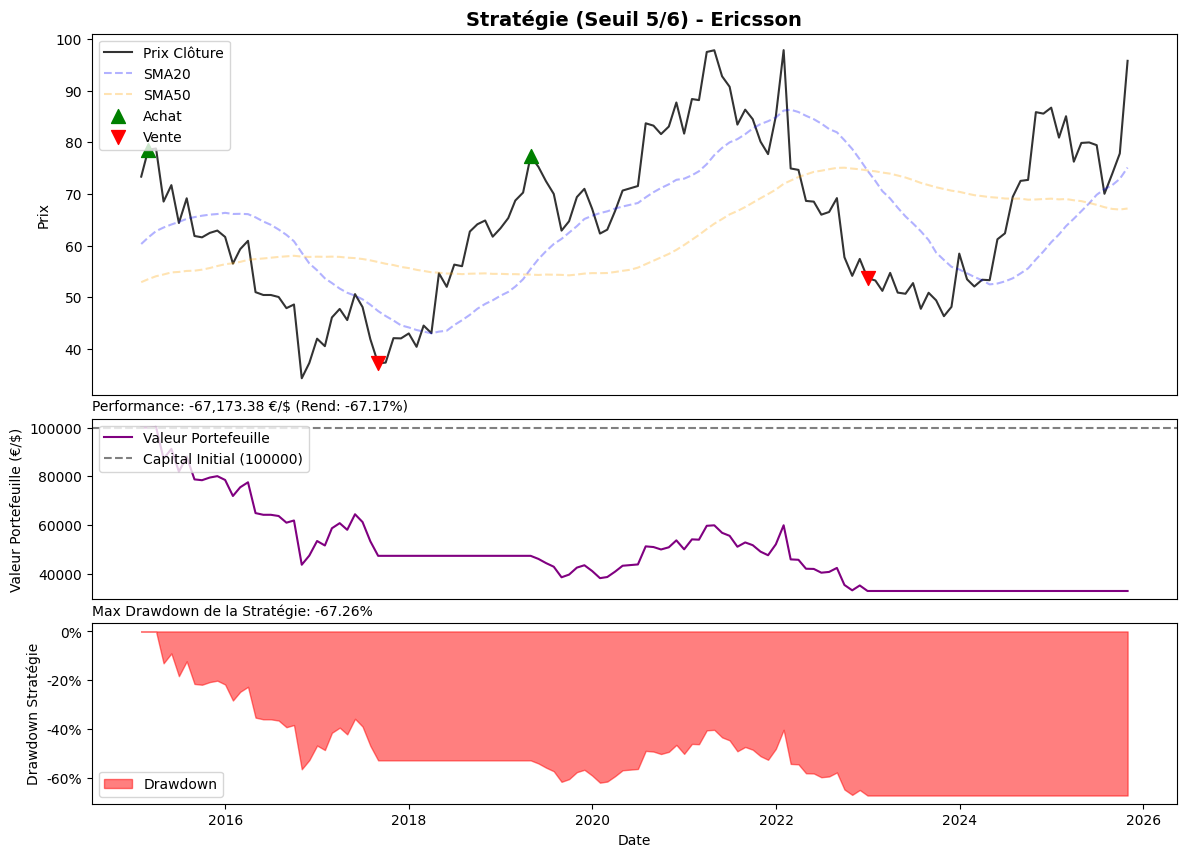

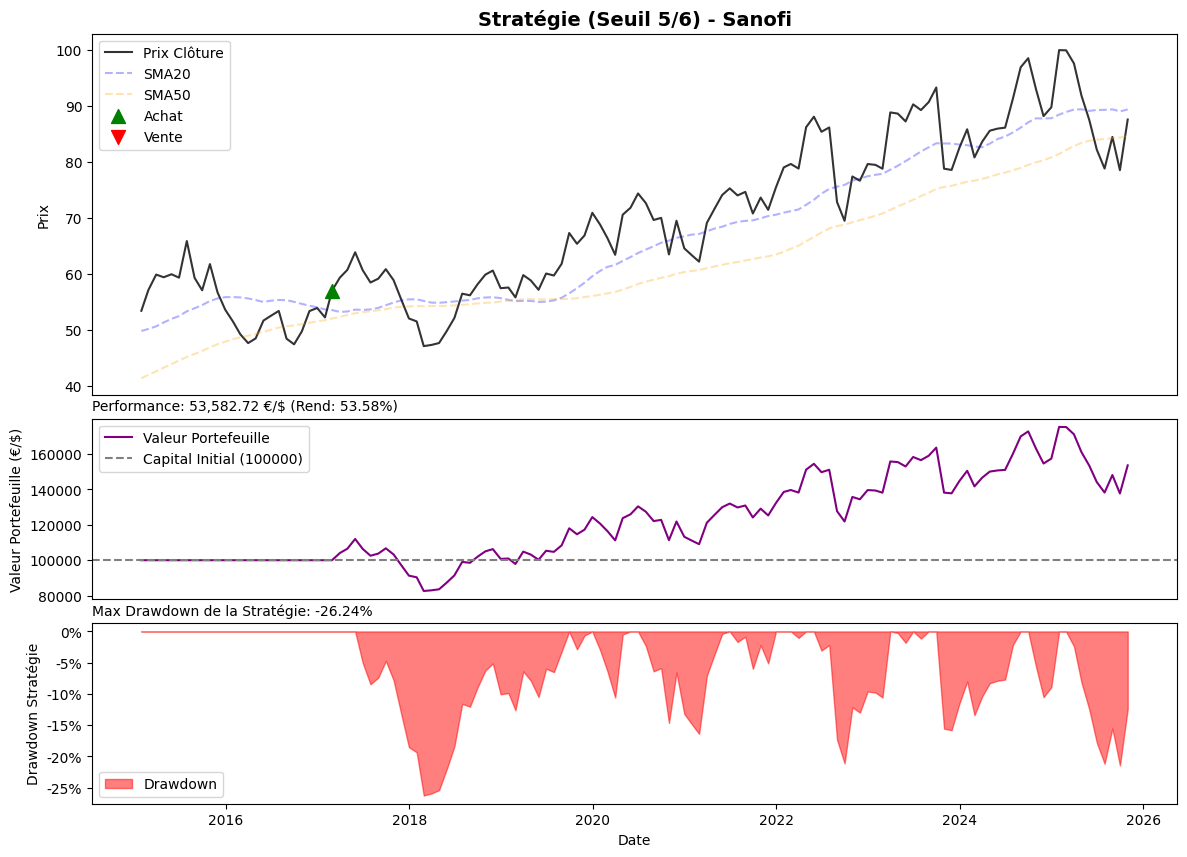

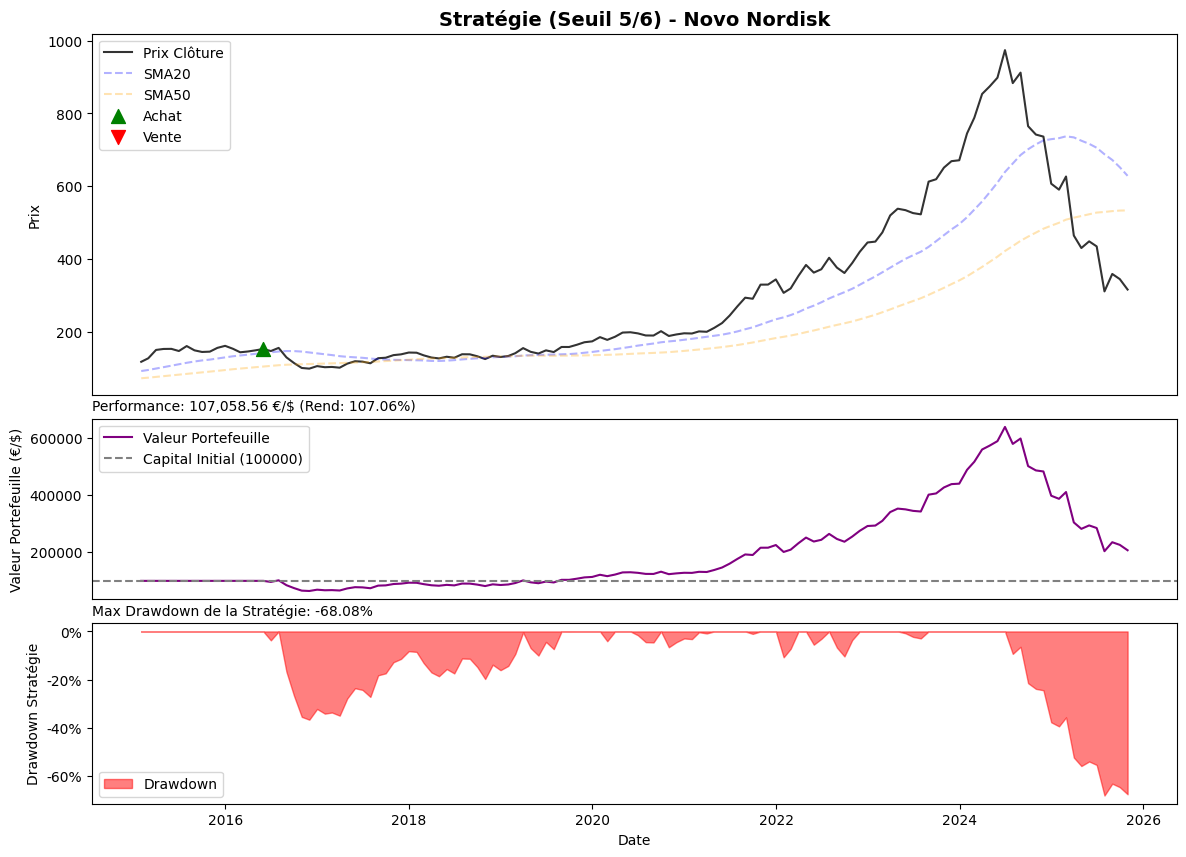

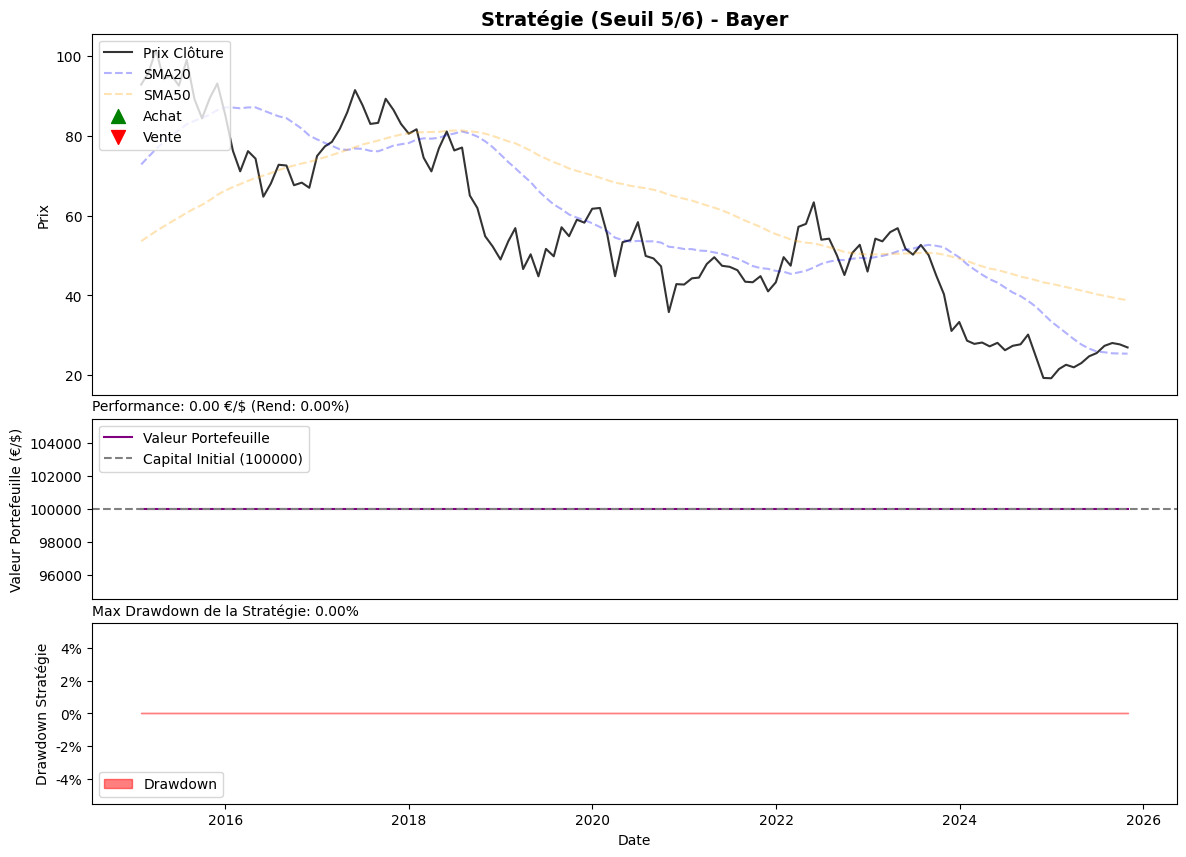

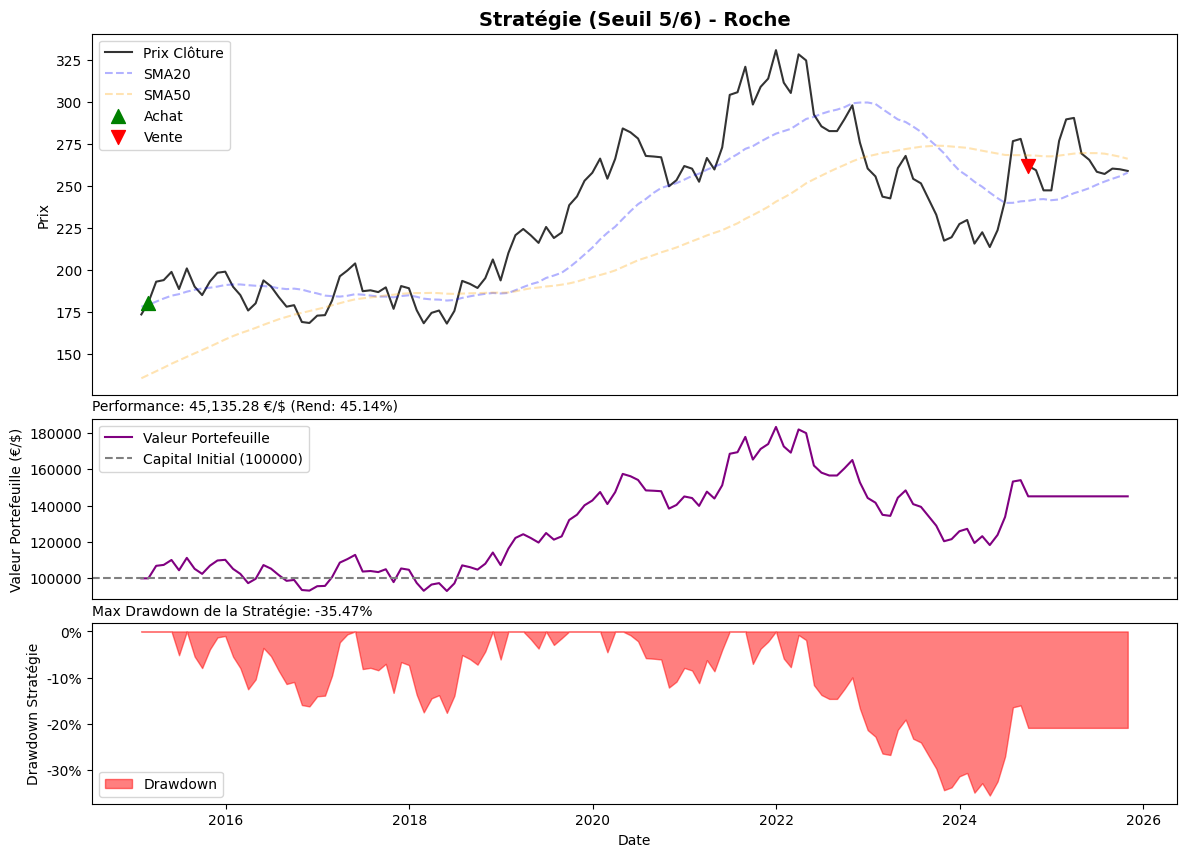

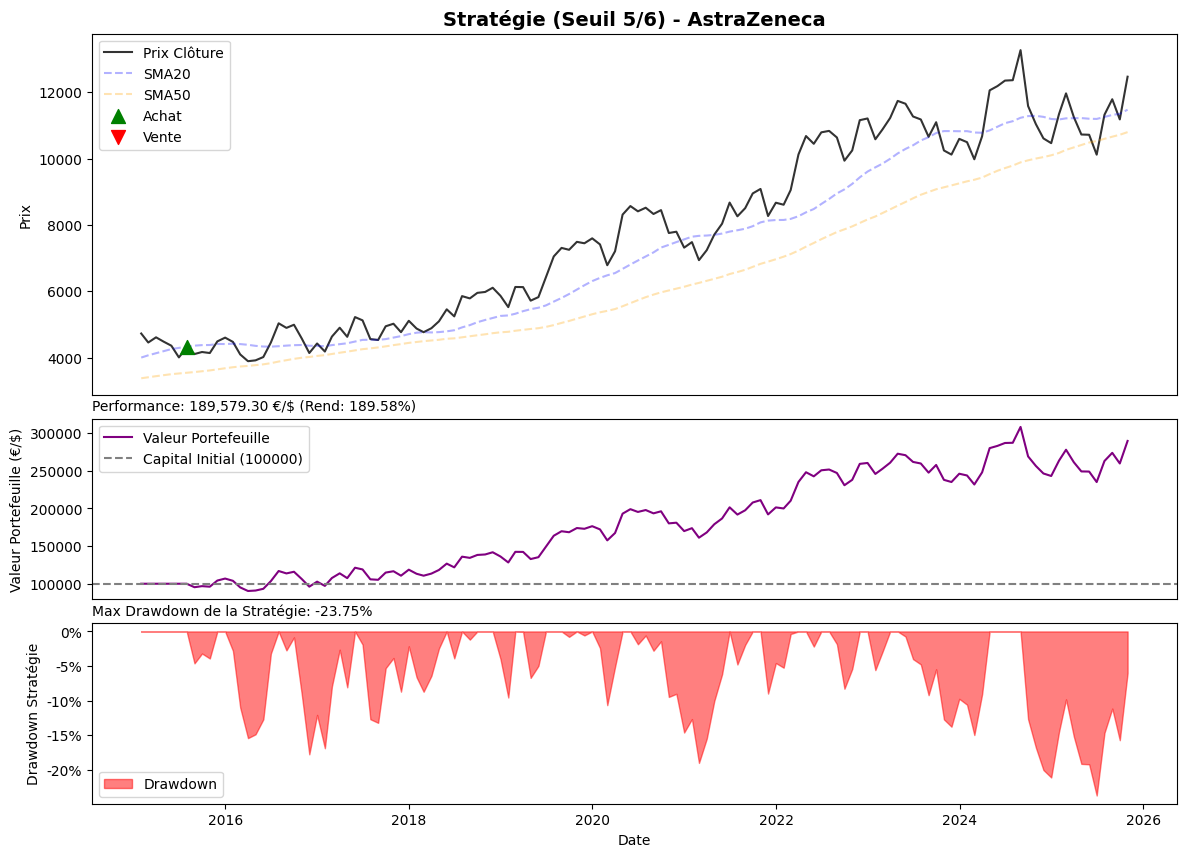

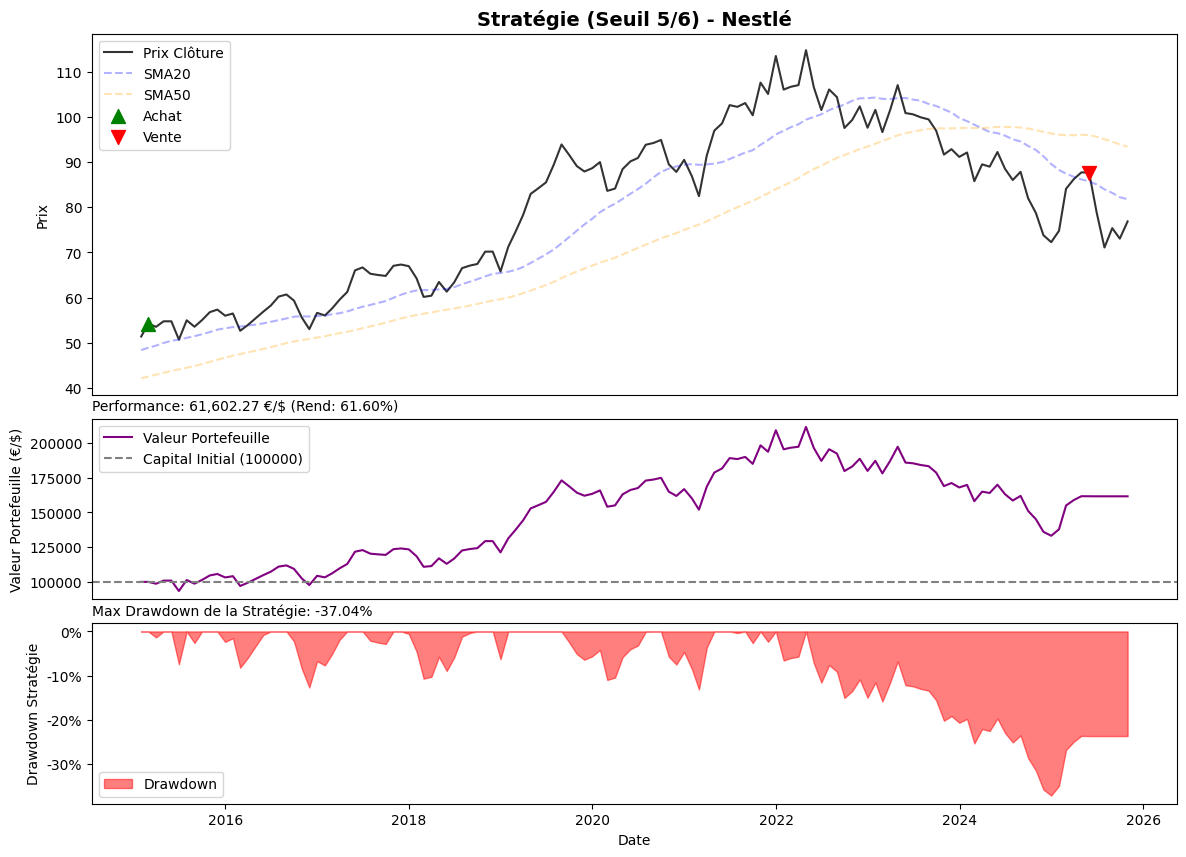

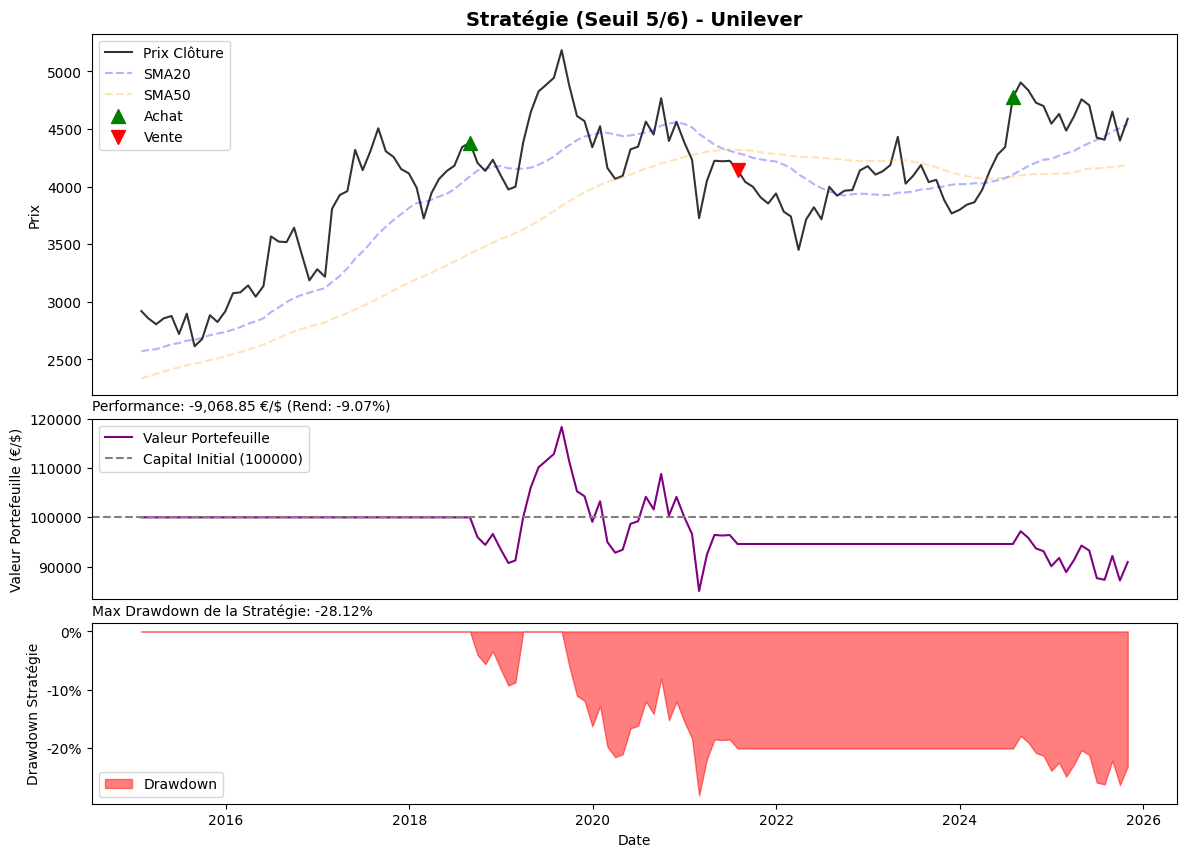

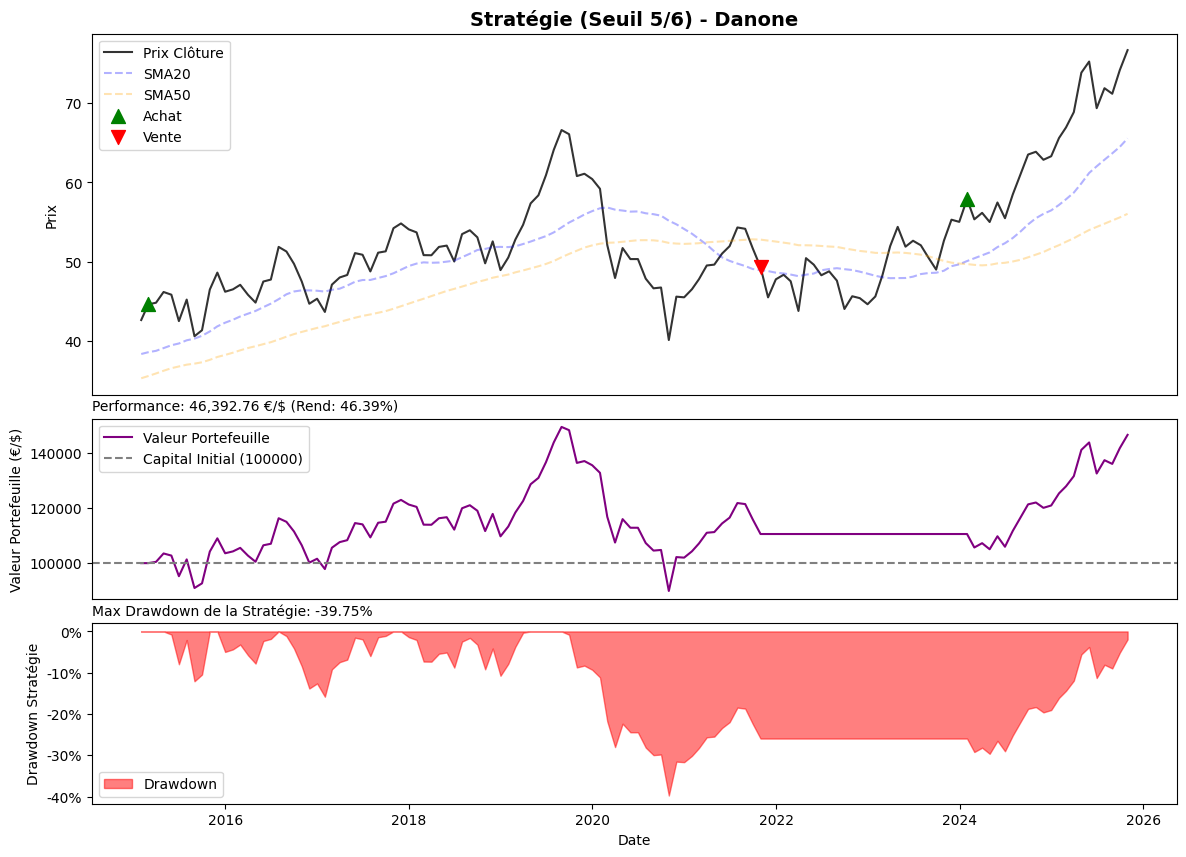

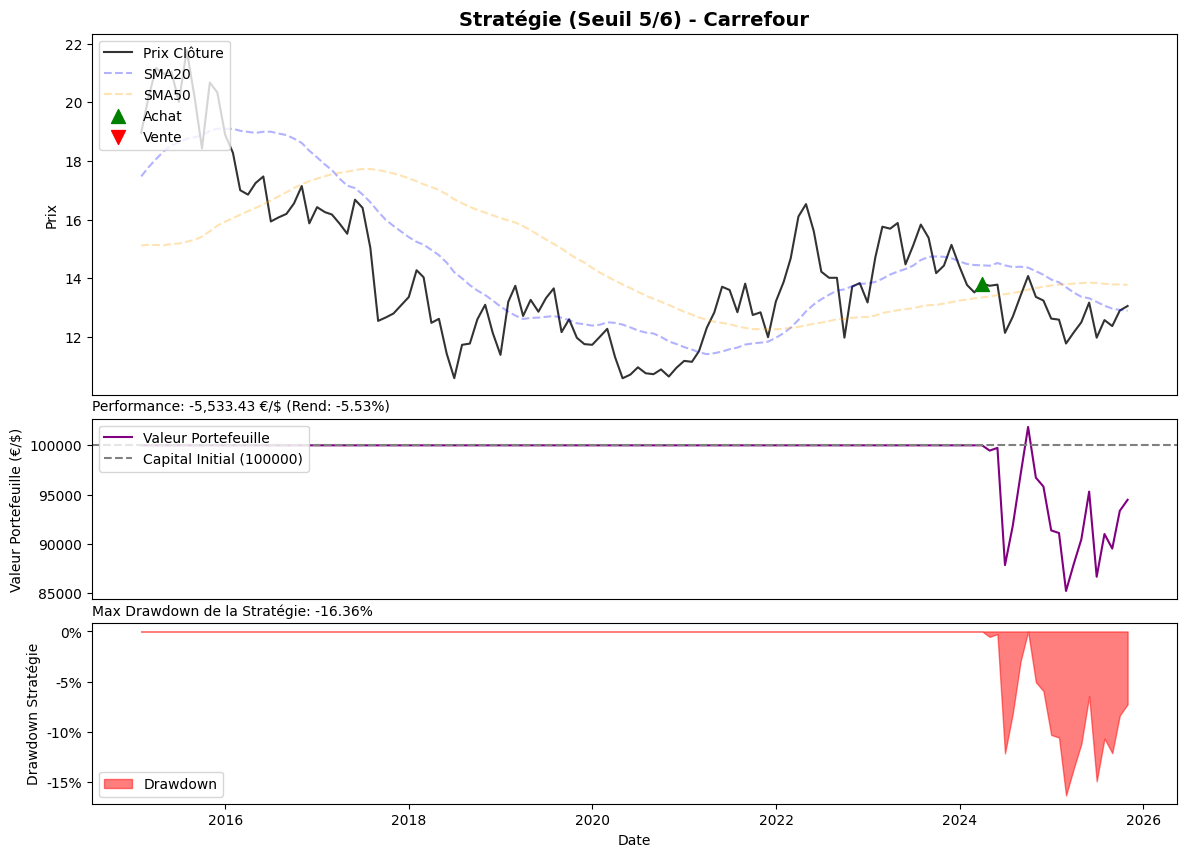

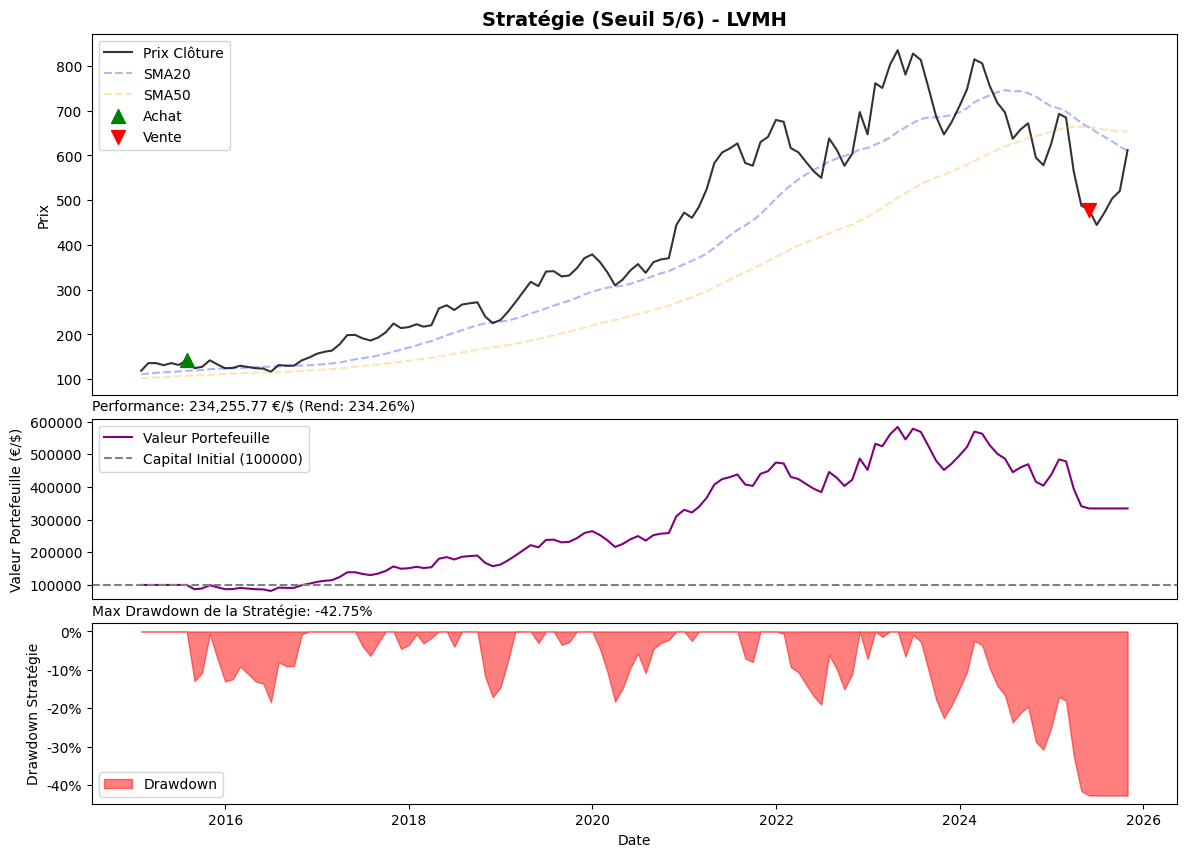

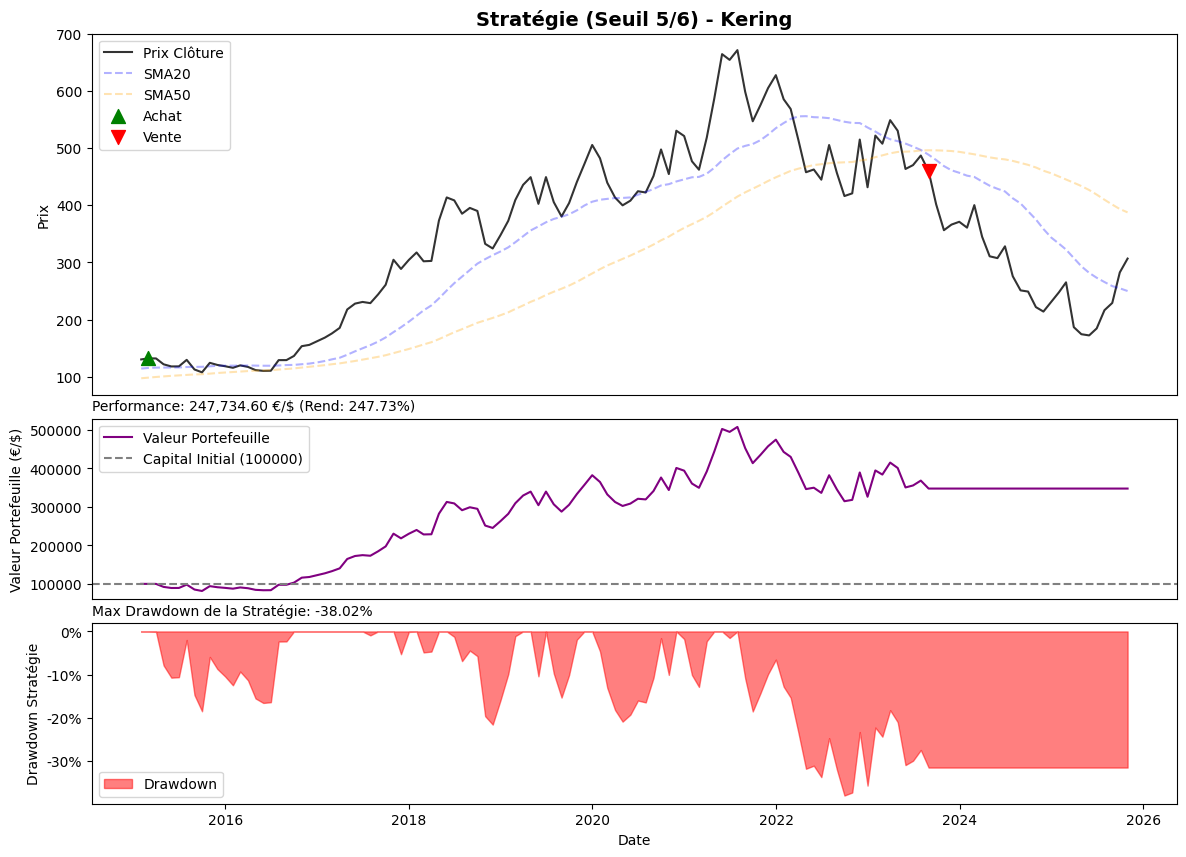

In [34]:
print(f"Utilisation du meilleur seuil identifié: {best_thr_label_eu}")

if 'data_dict_eu' in locals() and data_dict_eu:
    # Boucle sur chaque actif pour générer les graphiques
    for ticker in TICKERS_EU:
        if ticker in data_dict_eu:
            df_asset = data_dict_eu[ticker]
            ticker_label = TICKERS_LABEL_EU.get(ticker, ticker)
            
            backtest_results = run_visual_backtest(
                df=df_asset,
                thr=best_thr_num_eu,
                initial_capital=CAPITAL_INITIAL_EU
            )
            
            plot_backtest_results(
                df_asset=df_asset,
                backtest_results=backtest_results,
                ticker_label=ticker_label,
                thr=best_thr_num_eu
            )
        else:
            print(f"Pas de données pour {ticker}, impossible d'afficher le graphique.")
else:
    print("'data_dict_eu' non chargé. Exécutez la cellule 4.")

PARTIE 1 - Optimisation (Frontière Efficiente)


--- Graphique d'Optimisation (Frontière Efficiente) ---


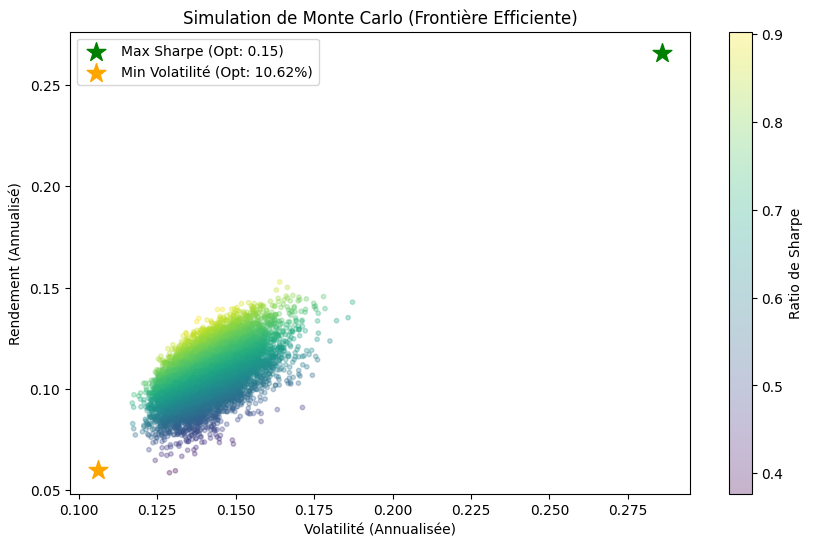

In [35]:
if 'data_dict_eu' in locals() and data_dict_eu:
    optimize_portfolio(
        df_dict=data_dict_eu,
        tickers=TICKERS_EU,
        risk_free_rate=RISK_FREE_RATE
    )
else:
    print("Données 'data_dict_eu' non trouvées. Exécutez la cellule 4.")

PARTIE 2 - Analyse Complète (Portefeuille US)

Données non trouvées ou obsolètes. Téléchargement et traitement...
Données sauvegardées dans : C:/Users/Karine/Desktop/Projet_gestion_portefeuille/df_dict_processed_monthly_US.pkl


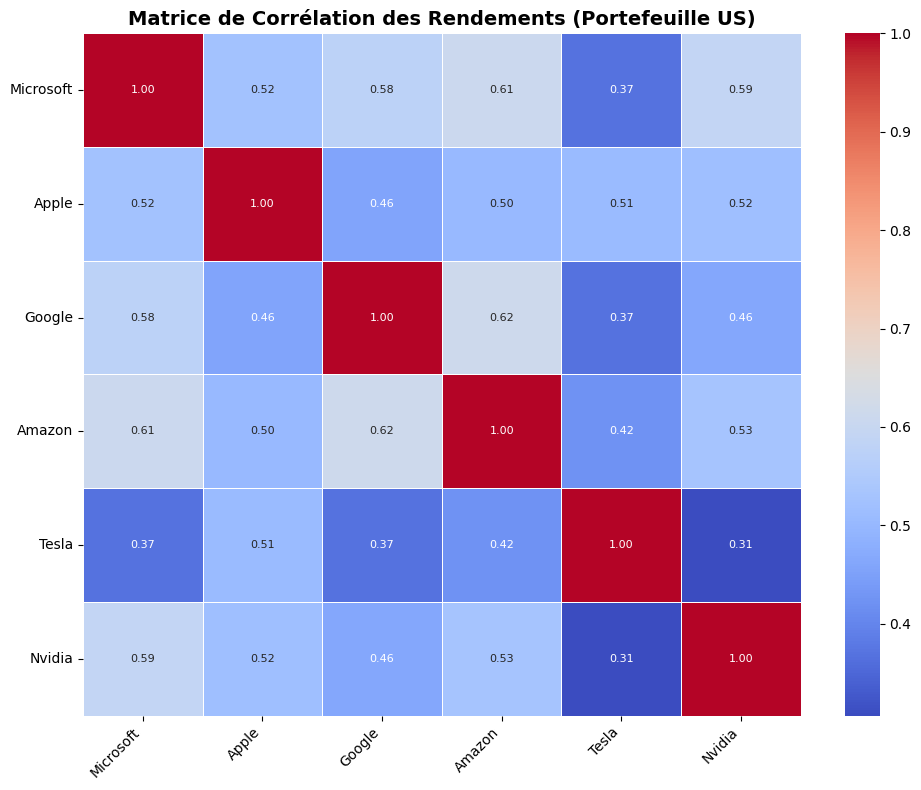


--- Analyse des Seuils de Stratégie pour: Portefeuille Secondaire (US) ---



Tableau de performance (Agrégé sur tous les actifs):
       Total Trades Win Rate Rendement Moyen
Seuil                                       
1/6             302   61.26%           3.34%
2/6             234   60.68%           4.98%
3/6             101   63.37%          13.61%
4/6               9   88.89%         314.83%
5/6               1  100.00%         200.86%
6/6               0      N/A             N/A

Meilleur seuil (basé sur Rendement Moyen) pour 'Portefeuille Secondaire (US)': 4/6 (Rend. Moyen: 314.83%)

Lancement du Backtest Visuel Détaillé (US) avec Seuil 4/6


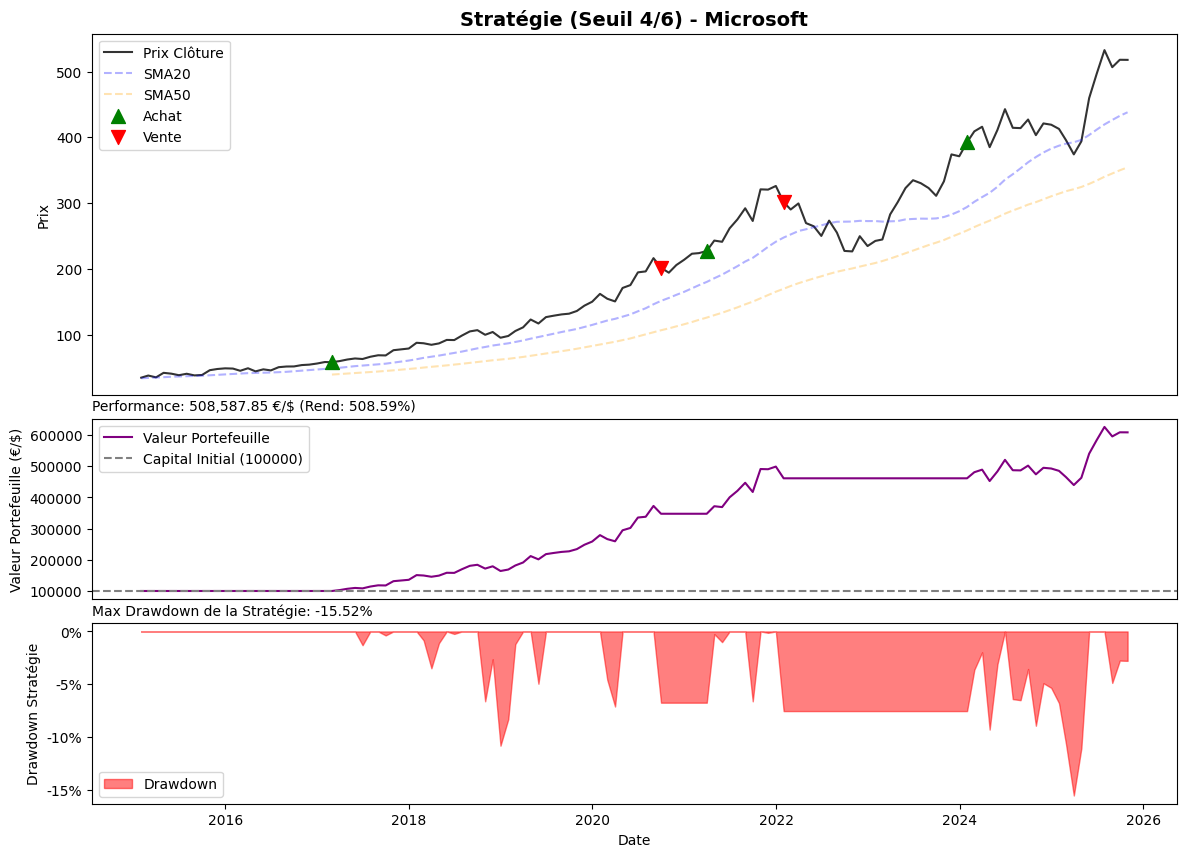

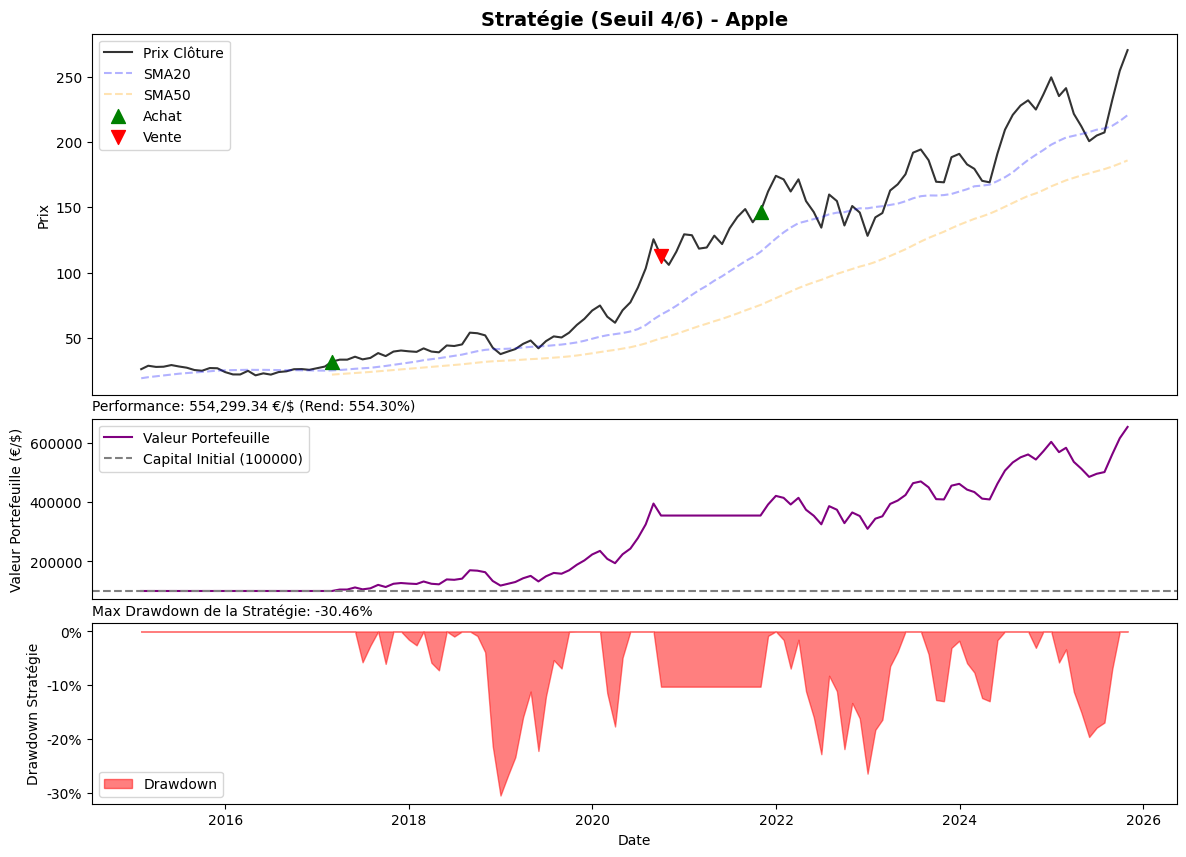

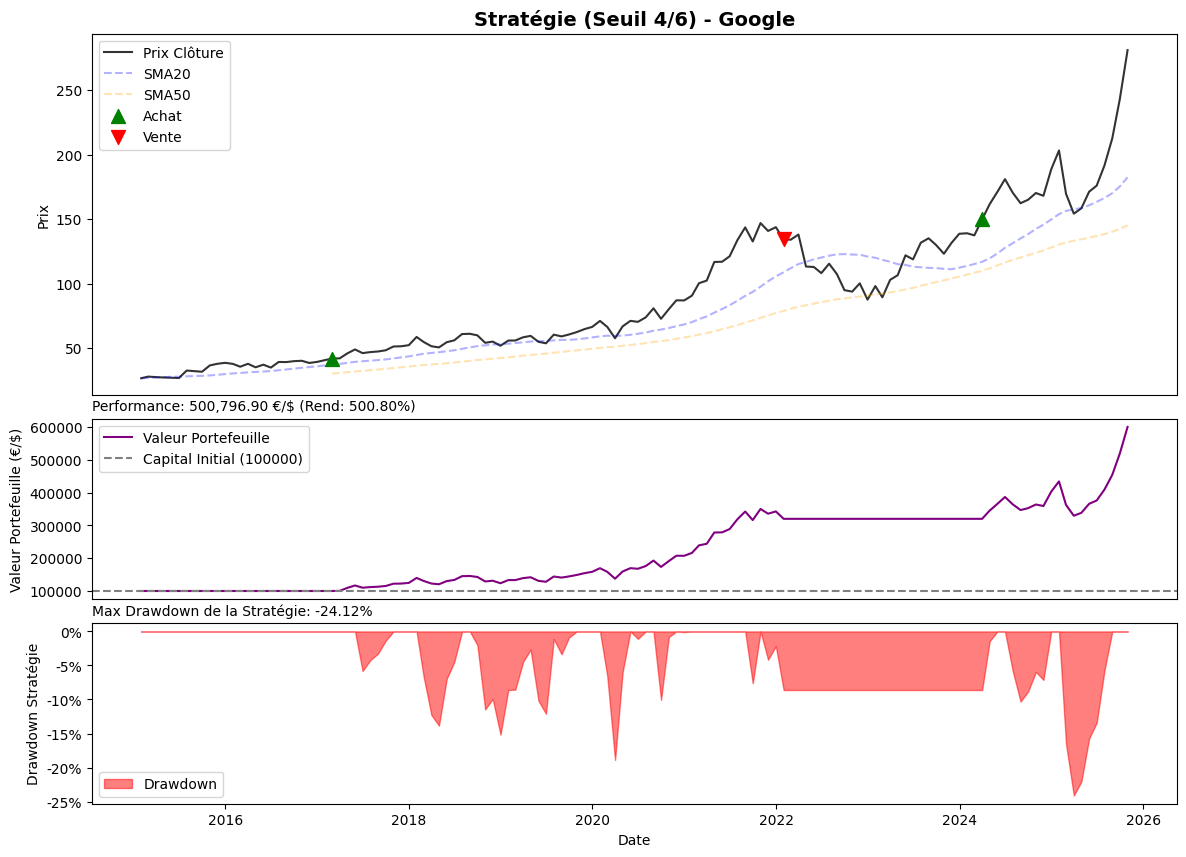

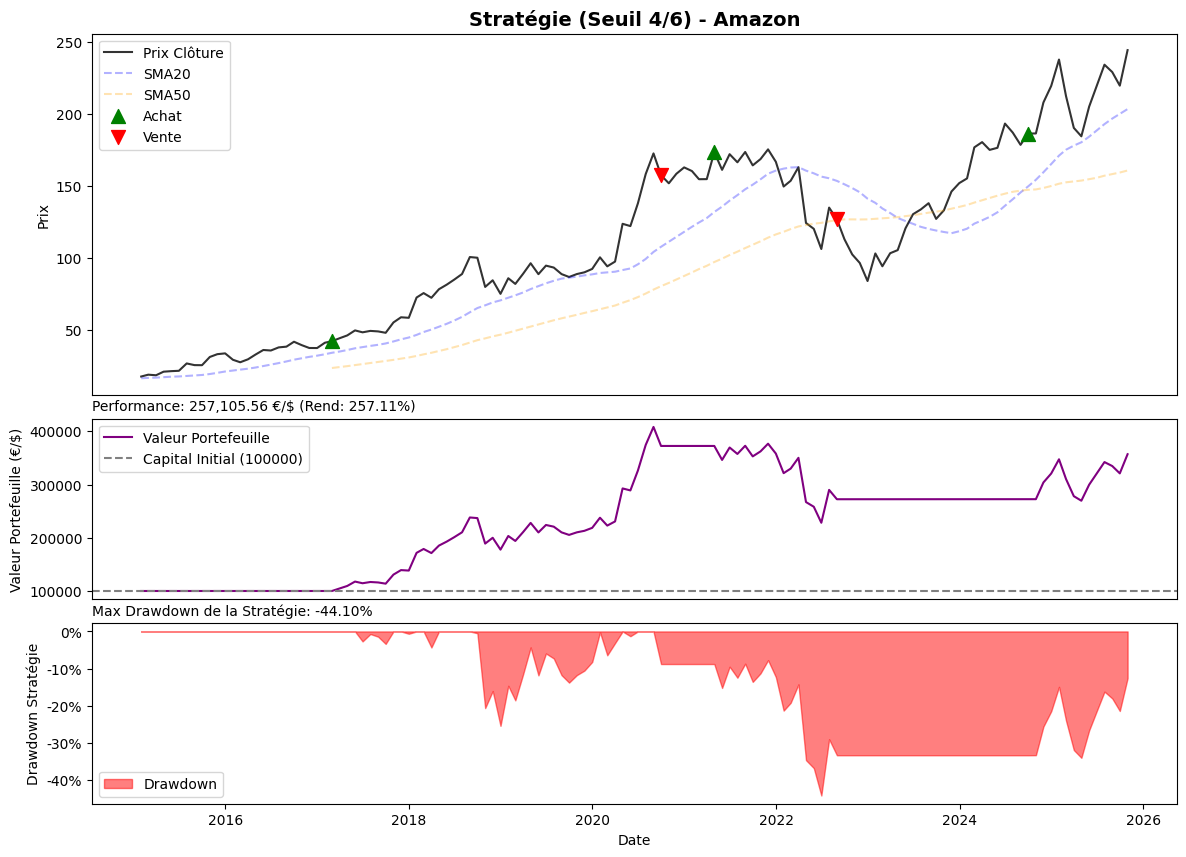

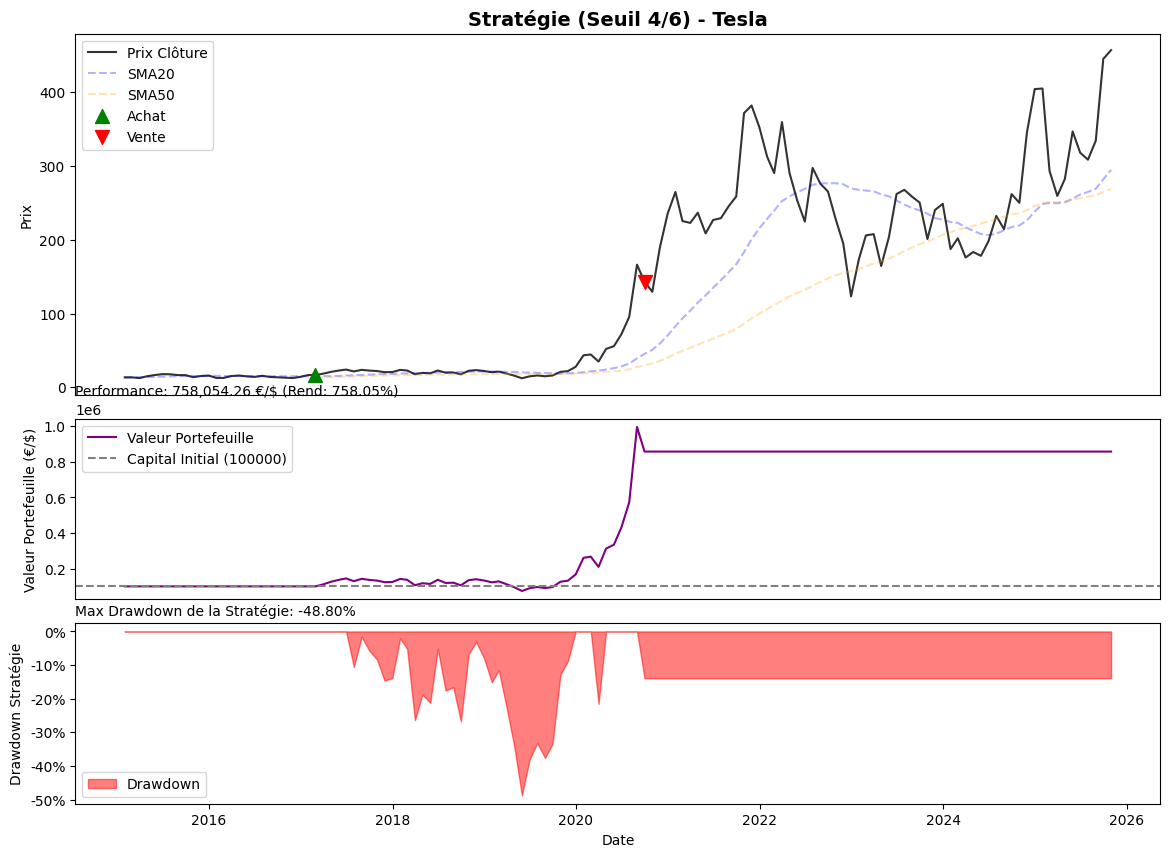

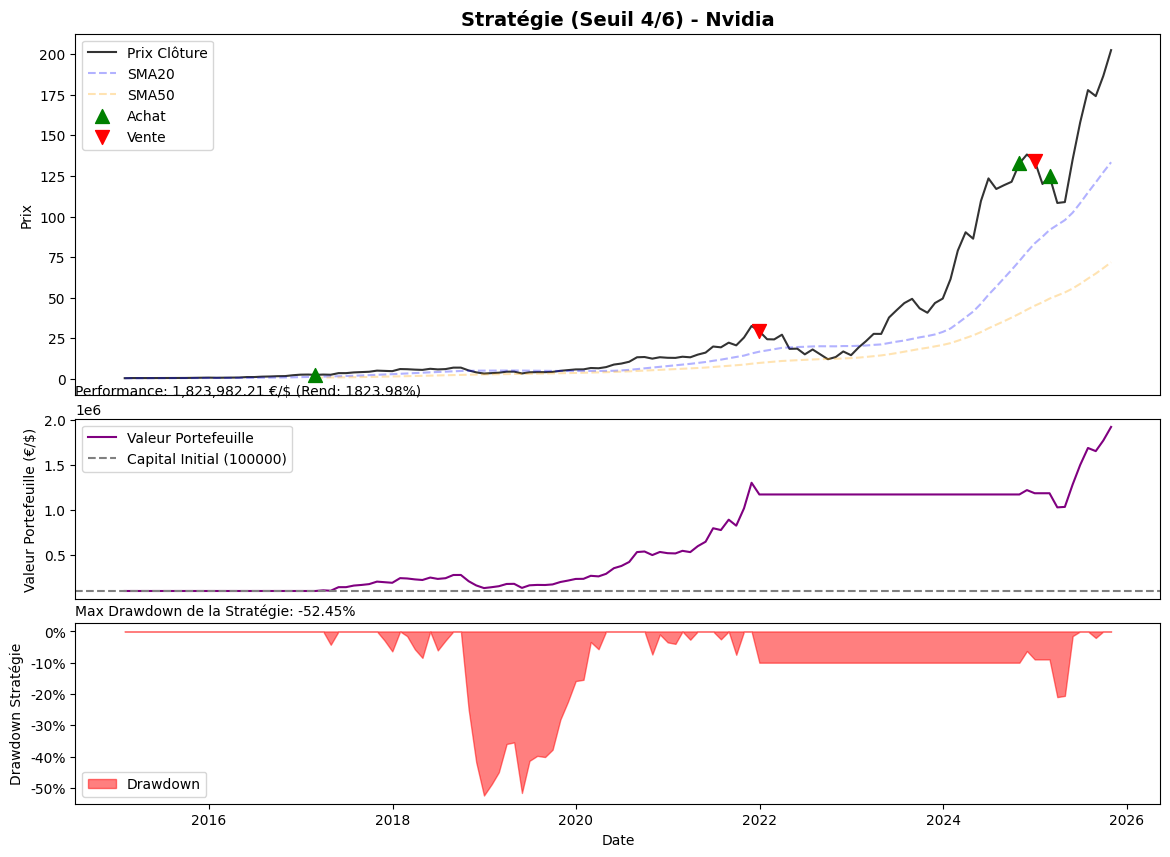

In [37]:
TICKERS_US = list(TICKERS_LABEL_US.keys())
PICKLE_PATH_US = os.path.join(OUTPUT_DIR, "df_dict_processed_monthly_US.pkl")
CAPITAL_INITIAL_US = 100000

# Étape 2.1: Chargement des données
data_dict_us = load_and_process_data(
    tickers=TICKERS_US,
    output_dir=OUTPUT_DIR,
    pickle_path=PICKLE_PATH_US,
    analysis_start=ANALYSIS_START,
    analysis_end=ANALYSIS_END,
    buffer_period=BUFFER_PERIOD,
    cols_to_convert=COLS_TO_CONVERT
)

if data_dict_us:
    # Étape 2.2: Analyse de Corrélation (US)
    plot_correlation_heatmap(data_dict_us, TICKERS_US, TICKERS_LABEL_US, 
                             title="Matrice de Corrélation des Rendements (Portefeuille US)")

    # Étape 2.3: Analyse des Seuils (US)
    results_us, best_thr_label_us, best_thr_num_us = analyze_thresholds(
        data_dict=data_dict_us,
        tickers_to_analyze=TICKERS_US,
        group_label="Portefeuille Secondaire (US)"
    )

    # Étape 2.4: Backtest Visuel Détaillé (US)
    print(f"\nLancement du Backtest Visuel Détaillé (US) avec Seuil {best_thr_label_us}")
    
    for ticker in TICKERS_US:
        if ticker in data_dict_us:
            df_asset_us = data_dict_us[ticker]
            ticker_label_us = TICKERS_LABEL_US.get(ticker, ticker)
            
            backtest_results_us = run_visual_backtest(
                df=df_asset_us,
                thr=best_thr_num_us,
                initial_capital=CAPITAL_INITIAL_US
            )
            
            plot_backtest_results(
                df_asset=df_asset_us,
                backtest_results=backtest_results_us,
                ticker_label=ticker_label_us,
                thr=best_thr_num_us
            )
        else:
            print(f"Pas de données pour {ticker} (US).")
            
else:
    print("Échec du chargement des données pour le portefeuille US.")

Analyse Finale - Tableau Récapitulatif PNL par Seuil

In [38]:
# Définition des fonctions pour cette analyse

def run_backtest_for_pnl(df, thr, initial_capital):
    """Exécute le backtest et retourne le PNL final en €/$. """
    if df is None or df.empty or len(df) < 2:
        return 0.0
    
    cash = initial_capital
    positions = 0.0
    in_position = False
    
    median_atr = df['ATR'].median()
    median_vol = df['Volatilite_12m'].median()
    
    if pd.isna(median_atr) or pd.isna(median_vol):
        return 0.0
        
    final_equity = initial_capital
    
    for i in range(1, len(df)):
        prev = df.iloc[i-1]
        curr = df.iloc[i]
        
        if in_position:
            if pd.notna(curr['Close']):
                final_equity = positions * curr['Close']
        else:
            final_equity = cash
        
        if pd.isna(curr['SMA20']) or pd.isna(curr['SMA50']) or pd.isna(curr['RSI']) or \
           pd.isna(curr['MACD']) or pd.isna(curr['ATR']) or pd.isna(curr['Volatilite_12m']):
            continue 
        
        if not in_position and buy_signal_threshold(prev, curr, median_atr, median_vol, thr):
            positions = cash / curr['Close']
            cash = 0.0
            in_position = True
            final_equity = positions * curr['Close']
        
        elif in_position and sell_signal_threshold(prev, curr, median_atr, median_vol, thr):
            cash = positions * curr['Close']
            positions = 0.0
            in_position = False
            final_equity = cash

    if pd.isna(final_equity):
        pnl = cash - initial_capital
    else:
        pnl = final_equity - initial_capital
        
    return pnl


def analyze_thresholds_pnl(data_dict, tickers_to_analyze, initial_capital_per_asset, group_label):
    """Analyse le PNL total du portefeuille pour chaque seuil."""
    print(f"\nAnalyse PNL Total par Seuil pour: {group_label}")
    print(f"Capital initial par actif: {initial_capital_per_asset:,.2f} €/$")
    
    all_pnl_metrics = []
    
    # Récupérer les stats de rendement moyen pour comparaison
    df_results_stats, _, _ = analyze_thresholds(data_dict, tickers_to_analyze, group_label)
    
    for thr in range(1, 7):
        total_pnl_for_thr = 0.0
        
        for ticker in tickers_to_analyze:
            if ticker in data_dict:
                df_asset = data_dict[ticker]
                pnl = run_backtest_for_pnl(df_asset, thr, initial_capital_per_asset)
                total_pnl_for_thr += pnl
        
        metrics = {
            'Seuil': f"{thr}/6",
            'PNL Total Portefeuille': total_pnl_for_thr
        }
        all_pnl_metrics.append(metrics)
    
    df_results = pd.DataFrame(all_pnl_metrics).set_index('Seuil')
    
    total_invested = initial_capital_per_asset * len(tickers_to_analyze)
    df_results['Rendement Global'] = df_results['PNL Total Portefeuille'] / total_invested
    
    df_results['Rendement Moyen / Trade'] = df_results_stats['Rendement Moyen']
    
    df_display = df_results.copy()
    df_display['PNL Total Portefeuille'] = df_display['PNL Total Portefeuille'].map(lambda x: f"{x:,.2f} €/$")
    df_display['Rendement Global'] = df_display['Rendement Global'].map(lambda x: f"{x:.2%}" if pd.notna(x) else "N/A")
    df_display['Rendement Moyen / Trade'] = df_display['Rendement Moyen / Trade'].map(lambda x: f"{x:.2%}" if pd.notna(x) else "N/A")
    
    print(f"\nTableau PNL (Agrégé sur {len(tickers_to_analyze)} actifs, Capital total investi: {total_invested:,.2f} €/$):")
    print(df_display[['PNL Total Portefeuille', 'Rendement Global', 'Rendement Moyen / Trade']])
    
    best_thr_idx = df_results['PNL Total Portefeuille'].idxmax()
    best_pnl = df_results.loc[best_thr_idx, 'PNL Total Portefeuille']
    print(f"\nMeilleur seuil (basé sur PNL Total): {best_thr_idx} (PNL: {best_pnl:,.2f} €/$)")
    
    return df_results

# 1. Portefeuille Principal (EU)
if 'data_dict_eu' in locals() and data_dict_eu:
    print("\nExécution Analyse PNL: Portefeuille Principal (EU)")
    analyze_thresholds_pnl(
        data_dict=data_dict_eu,
        tickers_to_analyze=TICKERS_EU,
        initial_capital_per_asset=CAPITAL_INITIAL_EU,
        group_label="Portefeuille Principal (EU)"
    )
else:
    print("'data_dict_eu' non trouvé. PNL EU non calculé")

# 2. Portefeuille Secondaire (US)
if 'data_dict_us' in locals() and data_dict_us:
    print("\nExécution Analyse PNL: Portefeuille Secondaire (US)")
    analyze_thresholds_pnl(
        data_dict=data_dict_us,
        tickers_to_analyze=TICKERS_US,
        initial_capital_per_asset=CAPITAL_INITIAL_US,
        group_label="Portefeuille Secondaire (US)"
    )
else:
    print("'data_dict_us' non trouvé. PNL US non calculé.")


Exécution Analyse PNL: Portefeuille Principal (EU)

Analyse PNL Total par Seuil pour: Portefeuille Principal (EU)
Capital initial par actif: 100,000.00 €/$

--- Analyse des Seuils de Stratégie pour: Portefeuille Principal (EU) ---



Tableau de performance (Agrégé sur tous les actifs):
       Total Trades Win Rate Rendement Moyen
Seuil                                       
1/6             968   52.58%           1.01%
2/6             701   47.79%           1.14%
3/6             266   43.61%           5.14%
4/6              37   51.35%          39.35%
5/6              10   70.00%          81.12%
6/6               0      N/A             N/A

Meilleur seuil (basé sur Rendement Moyen) pour 'Portefeuille Principal (EU)': 5/6 (Rend. Moyen: 81.12%)

Tableau PNL (Agrégé sur 16 actifs, Capital total investi: 1,600,000.00 €/$):
      PNL Total Portefeuille Rendement Global Rendement Moyen / Trade
Seuil                                                                
1/6         1,235,721.16 €/$           77.23%                   1.01%
2/6           946,557.93 €/$           59.16%                   1.14%
3/6         2,112,048.98 €/$          132.00%                   5.14%
4/6         1,716,203.73 €/$          107.26%        


Tableau de performance (Agrégé sur tous les actifs):
       Total Trades Win Rate Rendement Moyen
Seuil                                       
1/6             302   61.26%           3.34%
2/6             234   60.68%           4.98%
3/6             101   63.37%          13.61%
4/6               9   88.89%         314.83%
5/6               1  100.00%         200.86%
6/6               0      N/A             N/A

Meilleur seuil (basé sur Rendement Moyen) pour 'Portefeuille Secondaire (US)': 4/6 (Rend. Moyen: 314.83%)

Tableau PNL (Agrégé sur 6 actifs, Capital total investi: 600,000.00 €/$):
      PNL Total Portefeuille Rendement Global Rendement Moyen / Trade
Seuil                                                                
1/6         1,947,523.76 €/$          324.59%                   3.34%
2/6         2,728,158.92 €/$          454.69%                   4.98%
3/6         3,174,186.49 €/$          529.03%                  13.61%
4/6         4,402,826.11 €/$          733.80%         